# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [1]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = 'C:/Users/rober/Desktop/'
VIDEO_DIR = 'C:/Users/rober/Desktop/rhAirpuff/videos/'
file_container_obj = FileContainer(ROOT_DIR, VIDEO_DIR)

Session folder not found.
  Select .h5 behavior file (i.e. None_None_choice.h5)
  Select directory containing White Matter video files (i.e. None_None)
  Select directory containing SpikeGLX files (i.e. None_None_g0)
Behavior file selected: C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf_UnityVR_resampled.h5
  MonkeyLogic Date: 231223
  MonkeyLogic Monkey: gandalf
Video files directory selected: C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf
  White Matter Video Date: 231223
  White Matter Video Monkey: gandalf
SpikeGLX files directory selected: C:/Users/rober/Desktop/gandalf_20231223/gandalf_20231223_g0
  SpikeGLX Date: 231223
  SpikeGLX Monkey: gandalf



***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [2]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 367
Parsing session data...


  0%|          | 0/367 [00:00<?, ?it/s]

  joystick_y removed from session_dict
    0 trials in field != 366 trials in session
  Complete.
    Correct trials: 273
    Errored trials: 93
    Session Length:  00:24:34
Creating Session Objects...
Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...
   No novel fractal column found, skipping novel fractal...
   No fractal column found, skipping fractal count...


In [3]:
session_obj.df.head()

,date,session_num,subject,trial_num,block,condition,correct,error,error_type,behavioral_code_markers,behavioral_code_times,eye_x,eye_y,eye_pupil,joystick_x,cam_sync,cam_save,photodiode,trial_start,trial_end,trial_datetime_start,trial_datetime_end,Start trial,Frame skipped,Manual reward,End trial,Start,Reward,DEM_raster,trial_bins,trial_in_block,cam_frames
0,231223,0,gandalf,1,1,1,0,1,8,"[9, 10, 18]","[2.1411999769043177, 2869.1711999999825, 50927...","[7.0642227726292575, 7.038963511766996, 7.0389...","[-23.963056702177575, -23.824829215169203, -23...","[4051.0, 4051.0, 4051.0, 4054.0, 4054.0, 4064....","[[4051.0], [4051.0], [4051.0], [4054.0], [4054...","[3.332341437198878, 0.0013209363786366723, -0....","[3.3159000473854228, 3.327080192408092, 3.3080...","[0.5987999128048173, 0.5728225689217173, 0.590...",0.0000,77992.0000,2023-12-23 17:37:55.099,2023-12-23 17:39:13.091,2,<NA>,<NA>,50927,2869,<NA>,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",77992,0,"[5, 14, 22, 30, 39, 47, 55, 64, 72, 80, 89, 97..."
1,231223,0,gandalf,2,1,1,1,0,0,"[9, 10, 14, 50, 18]","[321.4086000225507, 393.3433000056539, 49357.0...","[18.66274639588813, 18.66274639588813, 18.6412...","[-5.227905523527922, -5.227905523527922, -5.25...","[7551.0, 7551.0, 7557.0, 7557.0, 7543.0, 7543....","[[7551.0], [7551.0], [7557.0], [7557.0], [7543...","[3.3159000473854228, 3.316886530761165, -0.000...","[3.324120742234178, 3.316557702969066, 3.31392...","[1.9476488998980859, 2.071616776569061, 1.9857...",50930.5945,80210.5945,2023-12-23 17:38:46.030,2023-12-23 17:39:15.310,321,<NA>,49357,58092,393,57579,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",29280,111,"[6, 14, 23, 31, 39, 48, 56, 64, 73, 81, 89, 98..."
2,231223,0,gandalf,3,1,1,1,0,0,"[9, 10, 50, 18]","[244.9037999904249, 312.6124999835156, 18548.3...","[-3.462277904521568, -3.462277904521568, -3.48...","[1.475546658196761, 1.475546658196761, 1.45454...","[4784.0, 4784.0, 4793.0, 4793.0, 4791.0, 4791....","[[4784.0], [4784.0], [4793.0], [4793.0], [4791...","[0.0072398264486985275, 0.005595690320483099, ...","[3.3418774435037144, 3.3191883253110372, 3.329...","[1.7487084309022984, 1.7039879321588909, 1.661...",109106.5228,128317.5228,2023-12-23 17:39:44.205,2023-12-23 17:40:03.416,244,<NA>,<NA>,19065,312,18548,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19211,222,"[4, 12, 21, 29, 37, 46, 54, 62, 71, 79, 87, 96..."
3,231223,0,gandalf,4,1,1,1,0,0,"[9, 10, 50, 18]","[193.0677999916952, 249.82959998305887, 12814....","[7.348621677865265, 7.348621677865265, 7.37095...","[-20.15054943834513, -20.15054943834513, -20.1...","[4599.0, 4599.0, 4599.0, 4599.0, 4603.0, 4608....","[[4599.0], [4599.0], [4599.0], [4599.0], [4603...","[3.313598252848495, 3.3129405972681782, 3.3162...","[3.3214901198699804, 3.333985576205767, 3.3376...","[2.030513367863869, 2.224521469441098, 2.06898...",128252.0063,141713.0063,2023-12-23 17:40:03.351,2023-12-23 17:40:16.812,193,<NA>,<NA>,13330,249,12814,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",13461,300,"[8, 16, 24, 33, 41, 49, 58, 66, 74, 83, 91, 99..."
4,231223,0,gandalf,5,1,1,1,0,0,"[9, 10, 50, 18]","[190.61379999038763, 265.7947999832686, 9763.4...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan], [nan], [nan], [nan], [nan], [nan], [na...","[3.3208324642807847, 0.00921278980017022, 0.00...","[3.3188594975176424, 3.3214901198699804, 3.311...","[2.0019053961914492, 1.870374499748171, 2.0449...",141663.0958,151795.0958,2023-12-23 17:40:16.763,2023-12-23 17:40:26.895,190,<NA>,<NA>,10277,265,9763,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10132,311,"[5, 13, 22, 30, 38, 47, 55, 63, 72, 80, 88, 97..."


In [14]:
import pickle
from config.h5_helper import pickler

dest_path = "/Users/rahimhashim/SynologyDrive/Rahim/aragorn_20240126"
dest_path = os.getcwd()
# dest_path = os.path.dirname(file_container_obj.ml_file_path)

pickler(True, 
        save_path=dest_path, 
        session_df=session_obj.df, 
        monkey_input='gandalf',
        experiment_name='VR',
        error_dict=error_dict, 
        behavioral_code_dict=behavioral_code_dict)

Saving .pickle files to: c:\Users\rober\Desktop\Monkey-Emotions
  Pickling 240126_gandalf_VR_behave.pkl
  Total time to pickle: 1.0195 sec


In [4]:
session_obj.df['Start trial'] = 0
# session_obj.df['End trial'] is the length of the photodiode signal for each trial
session_obj.df['End trial'] = [len(x) for x in session_obj.df['photodiode']]

In [5]:
session_obj.df.head(5)

,date,session_num,subject,trial_num,block,condition,correct,error,error_type,behavioral_code_markers,behavioral_code_times,eye_x,eye_y,eye_pupil,joystick_x,cam_sync,cam_save,photodiode,trial_start,trial_end,trial_datetime_start,trial_datetime_end,Start trial,Frame skipped,Manual reward,End trial,Start,Reward,DEM_raster,trial_bins,trial_in_block,cam_frames
0,231223,0,gandalf,1,1,1,0,1,8,"[9, 10, 18]","[2.1411999769043177, 2869.1711999999825, 50927...","[7.0642227726292575, 7.038963511766996, 7.0389...","[-23.963056702177575, -23.824829215169203, -23...","[4051.0, 4051.0, 4051.0, 4054.0, 4054.0, 4064....","[[4051.0], [4051.0], [4051.0], [4054.0], [4054...","[3.332341437198878, 0.0013209363786366723, -0....","[3.3159000473854228, 3.327080192408092, 3.3080...","[0.5987999128048173, 0.5728225689217173, 0.590...",0.0000,77992.0000,2023-12-23 17:37:55.099,2023-12-23 17:39:13.091,0,<NA>,<NA>,77992,2869,<NA>,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",77992,0,"[5, 14, 22, 30, 39, 47, 55, 64, 72, 80, 89, 97..."
1,231223,0,gandalf,2,1,1,1,0,0,"[9, 10, 14, 50, 18]","[321.4086000225507, 393.3433000056539, 49357.0...","[18.66274639588813, 18.66274639588813, 18.6412...","[-5.227905523527922, -5.227905523527922, -5.25...","[7551.0, 7551.0, 7557.0, 7557.0, 7543.0, 7543....","[[7551.0], [7551.0], [7557.0], [7557.0], [7543...","[3.3159000473854228, 3.316886530761165, -0.000...","[3.324120742234178, 3.316557702969066, 3.31392...","[1.9476488998980859, 2.071616776569061, 1.9857...",50930.5945,80210.5945,2023-12-23 17:38:46.030,2023-12-23 17:39:15.310,0,<NA>,49357,29280,393,57579,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",29280,111,"[6, 14, 23, 31, 39, 48, 56, 64, 73, 81, 89, 98..."
2,231223,0,gandalf,3,1,1,1,0,0,"[9, 10, 50, 18]","[244.9037999904249, 312.6124999835156, 18548.3...","[-3.462277904521568, -3.462277904521568, -3.48...","[1.475546658196761, 1.475546658196761, 1.45454...","[4784.0, 4784.0, 4793.0, 4793.0, 4791.0, 4791....","[[4784.0], [4784.0], [4793.0], [4793.0], [4791...","[0.0072398264486985275, 0.005595690320483099, ...","[3.3418774435037144, 3.3191883253110372, 3.329...","[1.7487084309022984, 1.7039879321588909, 1.661...",109106.5228,128317.5228,2023-12-23 17:39:44.205,2023-12-23 17:40:03.416,0,<NA>,<NA>,19211,312,18548,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19211,222,"[4, 12, 21, 29, 37, 46, 54, 62, 71, 79, 87, 96..."
3,231223,0,gandalf,4,1,1,1,0,0,"[9, 10, 50, 18]","[193.0677999916952, 249.82959998305887, 12814....","[7.348621677865265, 7.348621677865265, 7.37095...","[-20.15054943834513, -20.15054943834513, -20.1...","[4599.0, 4599.0, 4599.0, 4599.0, 4603.0, 4608....","[[4599.0], [4599.0], [4599.0], [4599.0], [4603...","[3.313598252848495, 3.3129405972681782, 3.3162...","[3.3214901198699804, 3.333985576205767, 3.3376...","[2.030513367863869, 2.224521469441098, 2.06898...",128252.0063,141713.0063,2023-12-23 17:40:03.351,2023-12-23 17:40:16.812,0,<NA>,<NA>,13461,249,12814,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",13461,300,"[8, 16, 24, 33, 41, 49, 58, 66, 74, 83, 91, 99..."
4,231223,0,gandalf,5,1,1,1,0,0,"[9, 10, 50, 18]","[190.61379999038763, 265.7947999832686, 9763.4...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan], [nan], [nan], [nan], [nan], [nan], [na...","[3.3208324642807847, 0.00921278980017022, 0.00...","[3.3188594975176424, 3.3214901198699804, 3.311...","[2.0019053961914492, 1.870374499748171, 2.0449...",141663.0958,151795.0958,2023-12-23 17:40:16.763,2023-12-23 17:40:26.895,0,<NA>,<NA>,10132,265,9763,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10132,311,"[5, 13, 22, 30, 38, 47, 55, 63, 72, 80, 88, 97..."


*** 
## Process SpikeGLX

Assign `signal_dict` channels manually based on how you set up the PXI board. `epochs` are the MonkeyLogic eventcodes within `session_obj.df` distinguishing epochs in the task that you will reference later to break up videos based on.

In [6]:
# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
if session_obj.monkey in ['aragorn', 'bear']:
  epochs = ['Start Trial', 'Fixation On', 'CS On',	
          'Trace Start', 'Outcome Start', 'End Trial']
else:
  epochs = ['Start trial', 'End trial']
print('Epochs:')
# Print each epoch on its own line
for epoch in epochs:
  print(f'  {epoch}')

Epochs:
  Start trial
  End trial


### Peek at SpikeGLX Analog Data
Always view the data you are working with before doing any type of analysis. Calling `read_SGLX` prompts a file selection tool (choose the .bin file that **must have the .meta file in the same directory as is the default for SpikeGLX output**), and `plot_channels_raw` allows for visualization of a window specified by [tStart - tEnd] **seconds**. 

Reading SGLX meta and bin files...
Select binary file
Bin File Path: C:\Users\rober\Desktop\gandalf_20231223\gandalf_20231223_g0\gandalf_20231223_g0_t0.nidq.bin
File Name: D://gandalf_20231223_g0/gandalf_20231223_g0_t0.nidq.bin
  Number of Channels: 9
  File Created: 2023-12-23T17:36:59
  File Length: 6040.45037399812
nChan: 9, nFileSamp: 12080867
 Complete.
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
  Using input arguments instead.
Sample Rate:  1999.994413
 Channel [0]: cam_sync
  Max Val: 3345.642
  Min Val: -6.104
 Channel [1]: cam_save
  Max Val: 3357.849
  Min Val: -20.142
 Channel [2]: lick
  Max Val: 152.283
  Min Val: -34.485
 Channel [3]: photodiode
  Max Val: 2217.712
  Min Val: 417.786
 Channel [4]: empty
 Channel [5]: empty
 Channel [6]: empty
 Channel [7]: empty
 Channel [8]: empty


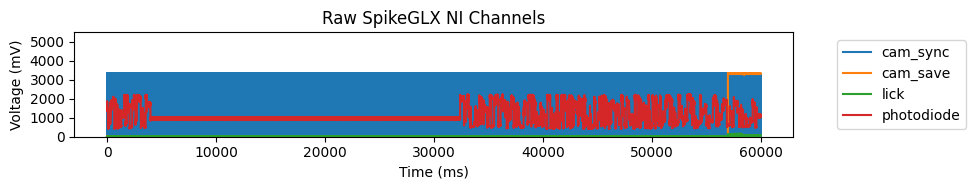

In [156]:
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, tStart=0, tEnd=60)

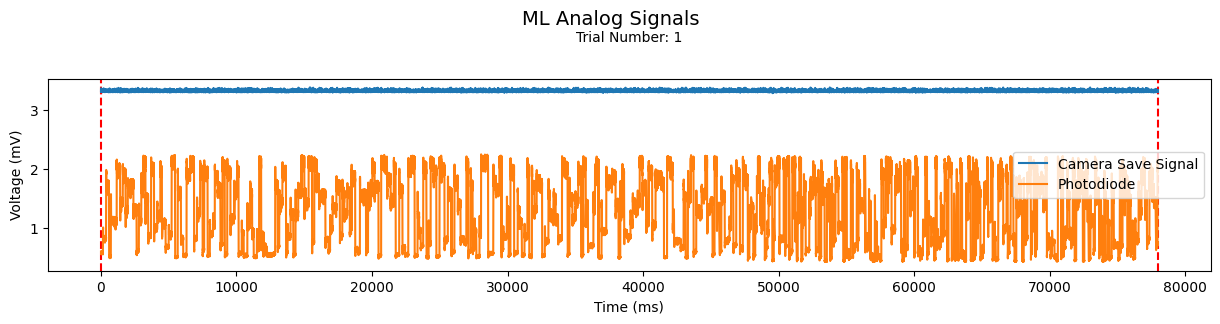

In [142]:
from spike_glx.read_SGLX import plot_analog_ML
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
plot_analog_ML(session_obj.df, epochs, trial_num=1)

In [7]:
from spike_glx.load_SGLX import load_sglx

# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

Found pickled spikeglx_obj: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\_data\gandalf_231223\spikeglx_obj_gandalf_231223.pkl
Updating spikeglx_obj paths...
  Updated sglx_dir_path to: C:/Users/rober/Desktop/gandalf_20231223
  Deleted old video_file_paths
  Deleted old video_info
  Updating video_file_paths and video_info...
Video Folders:
  231223_Gandalf_173755
  231223_Gandalf_174137
  231223_Gandalf_180501
Number of cameras: 5
  Camera: e3v831b | Number of videos: 5
  Camera: e3v8360 | Number of videos: 5
  Camera: e3v83ad | Number of videos: 5
  Camera: e3v83c5 | Number of videos: 5
  Camera: e3v83d6 | Number of videos: 5
Camera: e3v831b
  Video: e3v831b-20231223T173753-175754.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231223T175754-181754.avi | Frames: 144004 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231223T181754-183755.avi | Frames: 144124 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231223T18375

### ML-SpikeGLX Session Correlation
To see just the correlation matrix for each trial in a session, run `plot_spikeglx_ml_corr` with the newly-generated `spikeglx_obj`.

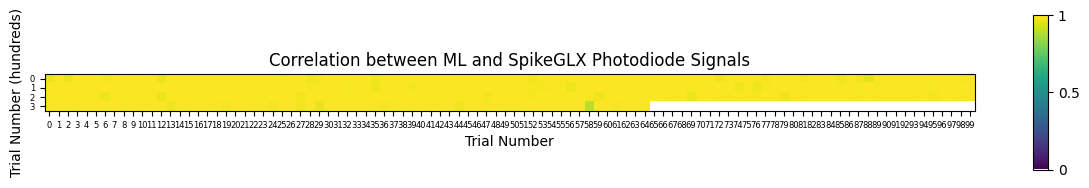

In [8]:
from spike_glx.read_SGLX import plot_spikeglx_ml_corr
plot_spikeglx_ml_corr(spikeglx_obj.ml_sglx_corr_matrix, 100)

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [9]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 247,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False,               # 'thread_flag': False
          'exclude_camera': ['e3v83c5']}      # 'exclude_camera': ['e3v83c5']        

parse_wm_videos(**kwargs)

Included Cameras: dict_keys(['e3v831b', 'e3v8360', 'e3v83ad', 'e3v83c5', 'e3v83d6'])
  Excluded Camera(s): ['e3v83c5']
Parsing Trials for Videos: 247 - 366
  Epoch Start: start
  Epoch End: end
  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v831b.mp4


Cam: e3v831b | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v831b | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v8360.mp4


Cam: e3v8360 | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v8360 | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83ad.mp4


Cam: e3v83ad | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v83ad | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143970 | Frame End: 432164
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83d6.mp4


Cam: e3v83d6 | Trial: 247 | Frames: 143970-432164:   0%|          | 0/288194 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1627


Cam: e3v83d6 | Trial: 247 | Frames: 0-1627:   0%|          | 0/1627 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v831b.mp4


Cam: e3v831b | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209


Cam: e3v8360 | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209


Cam: e3v83ad | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1629 | Frame End: 3296


Cam: e3v83d6 | Trial: 248 | Frames: 1629-3296:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v831b | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v8360 | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v83ad | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3297 | Frame End: 4969


Cam: e3v83d6 | Trial: 249 | Frames: 3297-4969:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v831b | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v8360 | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v83ad | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4970 | Frame End: 6724


Cam: e3v83d6 | Trial: 250 | Frames: 4970-6724:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v831b | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v8360 | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v83ad | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6726 | Frame End: 8691


Cam: e3v83d6 | Trial: 251 | Frames: 6726-8691:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v831b | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v8360 | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v83ad | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8692 | Frame End: 10415


Cam: e3v83d6 | Trial: 252 | Frames: 8692-10415:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v831b | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v8360 | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v83ad | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10416 | Frame End: 12249


Cam: e3v83d6 | Trial: 253 | Frames: 10416-12249:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v831b | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v8360 | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v83ad | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12249 | Frame End: 13854


Cam: e3v83d6 | Trial: 254 | Frames: 12249-13854:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v831b | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v8360 | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v83ad | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13854 | Frame End: 15405


Cam: e3v83d6 | Trial: 255 | Frames: 13854-15405:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v831b | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v8360 | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v83ad | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15406 | Frame End: 17181


Cam: e3v83d6 | Trial: 256 | Frames: 15406-17181:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v831b | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v8360 | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v83ad | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17182 | Frame End: 18629


Cam: e3v83d6 | Trial: 257 | Frames: 17182-18629:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v831b | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v8360 | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v83ad | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18630 | Frame End: 20755


Cam: e3v83d6 | Trial: 258 | Frames: 18630-20755:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v831b | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v8360 | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v83ad | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20756 | Frame End: 22657


Cam: e3v83d6 | Trial: 259 | Frames: 20756-22657:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v831b | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v8360 | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v83ad | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22658 | Frame End: 24692


Cam: e3v83d6 | Trial: 260 | Frames: 22658-24692:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v831b | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v8360 | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v83ad | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24693 | Frame End: 26568


Cam: e3v83d6 | Trial: 261 | Frames: 24693-26568:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v831b | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v8360 | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v83ad | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26570 | Frame End: 28290


Cam: e3v83d6 | Trial: 262 | Frames: 26570-28290:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v831b | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v8360 | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v83ad | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28291 | Frame End: 30293


Cam: e3v83d6 | Trial: 263 | Frames: 28291-30293:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v831b | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v8360 | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v83ad | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30294 | Frame End: 32004


Cam: e3v83d6 | Trial: 264 | Frames: 30294-32004:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v831b | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v8360 | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v83ad | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 32006 | Frame End: 34055


Cam: e3v83d6 | Trial: 265 | Frames: 32006-34055:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v831b | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v8360 | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v83ad | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 34056 | Frame End: 36021


Cam: e3v83d6 | Trial: 266 | Frames: 34056-36021:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v831b | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v8360 | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v83ad | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 36022 | Frame End: 37683


Cam: e3v83d6 | Trial: 267 | Frames: 36022-37683:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v831b | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v8360 | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v83ad | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37683 | Frame End: 39026


Cam: e3v83d6 | Trial: 268 | Frames: 37683-39026:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 38940 | Frame End: 40794


Cam: e3v831b | Trial: 269 | Frames: 38940-40794:   0%|          | 0/1854 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 38940 | Frame End: 40794


Cam: e3v8360 | Trial: 269 | Frames: 38940-40794:   0%|          | 0/1854 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 38940 | Frame End: 40794


Cam: e3v83ad | Trial: 269 | Frames: 38940-40794:   0%|          | 0/1854 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 39027 | Frame End: 40881


Cam: e3v83d6 | Trial: 269 | Frames: 39027-40881:   0%|          | 0/1854 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 40793 | Frame End: 42811


Cam: e3v831b | Trial: 270 | Frames: 40793-42811:   0%|          | 0/2018 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 40793 | Frame End: 42811


Cam: e3v8360 | Trial: 270 | Frames: 40793-42811:   0%|          | 0/2018 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 40793 | Frame End: 42811


Cam: e3v83ad | Trial: 270 | Frames: 40793-42811:   0%|          | 0/2018 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 40880 | Frame End: 42898


Cam: e3v83d6 | Trial: 270 | Frames: 40880-42898:   0%|          | 0/2018 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 42811 | Frame End: 44872


Cam: e3v831b | Trial: 271 | Frames: 42811-44872:   0%|          | 0/2061 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 42811 | Frame End: 44872


Cam: e3v8360 | Trial: 271 | Frames: 42811-44872:   0%|          | 0/2061 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 42811 | Frame End: 44872


Cam: e3v83ad | Trial: 271 | Frames: 42811-44872:   0%|          | 0/2061 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 42898 | Frame End: 44959


Cam: e3v83d6 | Trial: 271 | Frames: 42898-44959:   0%|          | 0/2061 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 44873 | Frame End: 46785


Cam: e3v831b | Trial: 272 | Frames: 44873-46785:   0%|          | 0/1912 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 44873 | Frame End: 46785


Cam: e3v8360 | Trial: 272 | Frames: 44873-46785:   0%|          | 0/1912 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 44873 | Frame End: 46785


Cam: e3v83ad | Trial: 272 | Frames: 44873-46785:   0%|          | 0/1912 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 44960 | Frame End: 46872


Cam: e3v83d6 | Trial: 272 | Frames: 44960-46872:   0%|          | 0/1912 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 46787 | Frame End: 48231


Cam: e3v831b | Trial: 273 | Frames: 46787-48231:   0%|          | 0/1444 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 46787 | Frame End: 48231


Cam: e3v8360 | Trial: 273 | Frames: 46787-48231:   0%|          | 0/1444 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 46787 | Frame End: 48231


Cam: e3v83ad | Trial: 273 | Frames: 46787-48231:   0%|          | 0/1444 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 46874 | Frame End: 48318


Cam: e3v83d6 | Trial: 273 | Frames: 46874-48318:   0%|          | 0/1444 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 48233 | Frame End: 50403


Cam: e3v831b | Trial: 274 | Frames: 48233-50403:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 48233 | Frame End: 50403


Cam: e3v8360 | Trial: 274 | Frames: 48233-50403:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 48233 | Frame End: 50403


Cam: e3v83ad | Trial: 274 | Frames: 48233-50403:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 48320 | Frame End: 50490


Cam: e3v83d6 | Trial: 274 | Frames: 48320-50490:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 50404 | Frame End: 52151


Cam: e3v831b | Trial: 275 | Frames: 50404-52151:   0%|          | 0/1747 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 50404 | Frame End: 52151


Cam: e3v8360 | Trial: 275 | Frames: 50404-52151:   0%|          | 0/1747 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 50404 | Frame End: 52151


Cam: e3v83ad | Trial: 275 | Frames: 50404-52151:   0%|          | 0/1747 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 50491 | Frame End: 52238


Cam: e3v83d6 | Trial: 275 | Frames: 50491-52238:   0%|          | 0/1747 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 52152 | Frame End: 53926


Cam: e3v831b | Trial: 276 | Frames: 52152-53926:   0%|          | 0/1774 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 52152 | Frame End: 53926


Cam: e3v8360 | Trial: 276 | Frames: 52152-53926:   0%|          | 0/1774 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 52152 | Frame End: 53926


Cam: e3v83ad | Trial: 276 | Frames: 52152-53926:   0%|          | 0/1774 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 52239 | Frame End: 54013


Cam: e3v83d6 | Trial: 276 | Frames: 52239-54013:   0%|          | 0/1774 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 53927 | Frame End: 56054


Cam: e3v831b | Trial: 277 | Frames: 53927-56054:   0%|          | 0/2127 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 53927 | Frame End: 56054


Cam: e3v8360 | Trial: 277 | Frames: 53927-56054:   0%|          | 0/2127 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 53927 | Frame End: 56054


Cam: e3v83ad | Trial: 277 | Frames: 53927-56054:   0%|          | 0/2127 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 54014 | Frame End: 56141


Cam: e3v83d6 | Trial: 277 | Frames: 54014-56141:   0%|          | 0/2127 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 56056 | Frame End: 57494


Cam: e3v831b | Trial: 278 | Frames: 56056-57494:   0%|          | 0/1438 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 56056 | Frame End: 57494


Cam: e3v8360 | Trial: 278 | Frames: 56056-57494:   0%|          | 0/1438 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 56056 | Frame End: 57494


Cam: e3v83ad | Trial: 278 | Frames: 56056-57494:   0%|          | 0/1438 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 56143 | Frame End: 57581


Cam: e3v83d6 | Trial: 278 | Frames: 56143-57581:   0%|          | 0/1438 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 57495 | Frame End: 59642


Cam: e3v831b | Trial: 279 | Frames: 57495-59642:   0%|          | 0/2147 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 57495 | Frame End: 59642


Cam: e3v8360 | Trial: 279 | Frames: 57495-59642:   0%|          | 0/2147 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 57495 | Frame End: 59642


Cam: e3v83ad | Trial: 279 | Frames: 57495-59642:   0%|          | 0/2147 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 57582 | Frame End: 59729


Cam: e3v83d6 | Trial: 279 | Frames: 57582-59729:   0%|          | 0/2147 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 59644 | Frame End: 61092


Cam: e3v831b | Trial: 280 | Frames: 59644-61092:   0%|          | 0/1448 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 59644 | Frame End: 61092


Cam: e3v8360 | Trial: 280 | Frames: 59644-61092:   0%|          | 0/1448 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 59644 | Frame End: 61092


Cam: e3v83ad | Trial: 280 | Frames: 59644-61092:   0%|          | 0/1448 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 59731 | Frame End: 61179


Cam: e3v83d6 | Trial: 280 | Frames: 59731-61179:   0%|          | 0/1448 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 61093 | Frame End: 62966


Cam: e3v831b | Trial: 281 | Frames: 61093-62966:   0%|          | 0/1873 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 61093 | Frame End: 62966


Cam: e3v8360 | Trial: 281 | Frames: 61093-62966:   0%|          | 0/1873 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 61093 | Frame End: 62966


Cam: e3v83ad | Trial: 281 | Frames: 61093-62966:   0%|          | 0/1873 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 61180 | Frame End: 63053


Cam: e3v83d6 | Trial: 281 | Frames: 61180-63053:   0%|          | 0/1873 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 62967 | Frame End: 64735


Cam: e3v831b | Trial: 282 | Frames: 62967-64735:   0%|          | 0/1768 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 62967 | Frame End: 64735


Cam: e3v8360 | Trial: 282 | Frames: 62967-64735:   0%|          | 0/1768 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 62967 | Frame End: 64735


Cam: e3v83ad | Trial: 282 | Frames: 62967-64735:   0%|          | 0/1768 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 63054 | Frame End: 64822


Cam: e3v83d6 | Trial: 282 | Frames: 63054-64822:   0%|          | 0/1768 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 64735 | Frame End: 66760


Cam: e3v831b | Trial: 283 | Frames: 64735-66760:   0%|          | 0/2025 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 64735 | Frame End: 66760


Cam: e3v8360 | Trial: 283 | Frames: 64735-66760:   0%|          | 0/2025 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 64735 | Frame End: 66760


Cam: e3v83ad | Trial: 283 | Frames: 64735-66760:   0%|          | 0/2025 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 64822 | Frame End: 66847


Cam: e3v83d6 | Trial: 283 | Frames: 64822-66847:   0%|          | 0/2025 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 66760 | Frame End: 68930


Cam: e3v831b | Trial: 284 | Frames: 66760-68930:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 66760 | Frame End: 68930


Cam: e3v8360 | Trial: 284 | Frames: 66760-68930:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 66760 | Frame End: 68930


Cam: e3v83ad | Trial: 284 | Frames: 66760-68930:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 66847 | Frame End: 69017


Cam: e3v83d6 | Trial: 284 | Frames: 66847-69017:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 68929 | Frame End: 70914


Cam: e3v831b | Trial: 285 | Frames: 68929-70914:   0%|          | 0/1985 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 68929 | Frame End: 70914


Cam: e3v8360 | Trial: 285 | Frames: 68929-70914:   0%|          | 0/1985 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 68929 | Frame End: 70914


Cam: e3v83ad | Trial: 285 | Frames: 68929-70914:   0%|          | 0/1985 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 69016 | Frame End: 71001


Cam: e3v83d6 | Trial: 285 | Frames: 69016-71001:   0%|          | 0/1985 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 70915 | Frame End: 73176


Cam: e3v831b | Trial: 286 | Frames: 70915-73176:   0%|          | 0/2261 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 70915 | Frame End: 73176


Cam: e3v8360 | Trial: 286 | Frames: 70915-73176:   0%|          | 0/2261 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 70915 | Frame End: 73176


Cam: e3v83ad | Trial: 286 | Frames: 70915-73176:   0%|          | 0/2261 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 71002 | Frame End: 73263


Cam: e3v83d6 | Trial: 286 | Frames: 71002-73263:   0%|          | 0/2261 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 73176 | Frame End: 75544


Cam: e3v831b | Trial: 287 | Frames: 73176-75544:   0%|          | 0/2368 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 73176 | Frame End: 75544


Cam: e3v8360 | Trial: 287 | Frames: 73176-75544:   0%|          | 0/2368 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 73176 | Frame End: 75544


Cam: e3v83ad | Trial: 287 | Frames: 73176-75544:   0%|          | 0/2368 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 73263 | Frame End: 75631


Cam: e3v83d6 | Trial: 287 | Frames: 73263-75631:   0%|          | 0/2368 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 75544 | Frame End: 77111


Cam: e3v831b | Trial: 288 | Frames: 75544-77111:   0%|          | 0/1567 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 75544 | Frame End: 77111


Cam: e3v8360 | Trial: 288 | Frames: 75544-77111:   0%|          | 0/1567 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 75544 | Frame End: 77111


Cam: e3v83ad | Trial: 288 | Frames: 75544-77111:   0%|          | 0/1567 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 75631 | Frame End: 77198


Cam: e3v83d6 | Trial: 288 | Frames: 75631-77198:   0%|          | 0/1567 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 77112 | Frame End: 79178


Cam: e3v831b | Trial: 289 | Frames: 77112-79178:   0%|          | 0/2066 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 77112 | Frame End: 79178


Cam: e3v8360 | Trial: 289 | Frames: 77112-79178:   0%|          | 0/2066 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 77112 | Frame End: 79178


Cam: e3v83ad | Trial: 289 | Frames: 77112-79178:   0%|          | 0/2066 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 77199 | Frame End: 79265


Cam: e3v83d6 | Trial: 289 | Frames: 77199-79265:   0%|          | 0/2066 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 79178 | Frame End: 80821


Cam: e3v831b | Trial: 290 | Frames: 79178-80821:   0%|          | 0/1643 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 79178 | Frame End: 80821


Cam: e3v8360 | Trial: 290 | Frames: 79178-80821:   0%|          | 0/1643 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 79178 | Frame End: 80821


Cam: e3v83ad | Trial: 290 | Frames: 79178-80821:   0%|          | 0/1643 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 79265 | Frame End: 80908


Cam: e3v83d6 | Trial: 290 | Frames: 79265-80908:   0%|          | 0/1643 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 80822 | Frame End: 82948


Cam: e3v831b | Trial: 291 | Frames: 80822-82948:   0%|          | 0/2126 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 80822 | Frame End: 82948


Cam: e3v8360 | Trial: 291 | Frames: 80822-82948:   0%|          | 0/2126 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 80822 | Frame End: 82948


Cam: e3v83ad | Trial: 291 | Frames: 80822-82948:   0%|          | 0/2126 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 80909 | Frame End: 83035


Cam: e3v83d6 | Trial: 291 | Frames: 80909-83035:   0%|          | 0/2126 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 82949 | Frame End: 84762


Cam: e3v831b | Trial: 292 | Frames: 82949-84762:   0%|          | 0/1813 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 82949 | Frame End: 84762


Cam: e3v8360 | Trial: 292 | Frames: 82949-84762:   0%|          | 0/1813 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 82949 | Frame End: 84762


Cam: e3v83ad | Trial: 292 | Frames: 82949-84762:   0%|          | 0/1813 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 83036 | Frame End: 84849


Cam: e3v83d6 | Trial: 292 | Frames: 83036-84849:   0%|          | 0/1813 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 84762 | Frame End: 86351


Cam: e3v831b | Trial: 293 | Frames: 84762-86351:   0%|          | 0/1589 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 84762 | Frame End: 86351


Cam: e3v8360 | Trial: 293 | Frames: 84762-86351:   0%|          | 0/1589 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 84762 | Frame End: 86351


Cam: e3v83ad | Trial: 293 | Frames: 84762-86351:   0%|          | 0/1589 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 84849 | Frame End: 86438


Cam: e3v83d6 | Trial: 293 | Frames: 84849-86438:   0%|          | 0/1589 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 86351 | Frame End: 88230


Cam: e3v831b | Trial: 294 | Frames: 86351-88230:   0%|          | 0/1879 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 86351 | Frame End: 88230


Cam: e3v8360 | Trial: 294 | Frames: 86351-88230:   0%|          | 0/1879 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 86351 | Frame End: 88230


Cam: e3v83ad | Trial: 294 | Frames: 86351-88230:   0%|          | 0/1879 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 86438 | Frame End: 88317


Cam: e3v83d6 | Trial: 294 | Frames: 86438-88317:   0%|          | 0/1879 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 88230 | Frame End: 89679


Cam: e3v831b | Trial: 295 | Frames: 88230-89679:   0%|          | 0/1449 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 88230 | Frame End: 89679


Cam: e3v8360 | Trial: 295 | Frames: 88230-89679:   0%|          | 0/1449 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 88230 | Frame End: 89679


Cam: e3v83ad | Trial: 295 | Frames: 88230-89679:   0%|          | 0/1449 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 88317 | Frame End: 89766


Cam: e3v83d6 | Trial: 295 | Frames: 88317-89766:   0%|          | 0/1449 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 89680 | Frame End: 91511


Cam: e3v831b | Trial: 296 | Frames: 89680-91511:   0%|          | 0/1831 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 89680 | Frame End: 91511


Cam: e3v8360 | Trial: 296 | Frames: 89680-91511:   0%|          | 0/1831 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 89680 | Frame End: 91511


Cam: e3v83ad | Trial: 296 | Frames: 89680-91511:   0%|          | 0/1831 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 89767 | Frame End: 91598


Cam: e3v83d6 | Trial: 296 | Frames: 89767-91598:   0%|          | 0/1831 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 91513 | Frame End: 93005


Cam: e3v831b | Trial: 297 | Frames: 91513-93005:   0%|          | 0/1492 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 91513 | Frame End: 93005


Cam: e3v8360 | Trial: 297 | Frames: 91513-93005:   0%|          | 0/1492 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 91513 | Frame End: 93005


Cam: e3v83ad | Trial: 297 | Frames: 91513-93005:   0%|          | 0/1492 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 91600 | Frame End: 93092


Cam: e3v83d6 | Trial: 297 | Frames: 91600-93092:   0%|          | 0/1492 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 93006 | Frame End: 94716


Cam: e3v831b | Trial: 298 | Frames: 93006-94716:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 93006 | Frame End: 94716


Cam: e3v8360 | Trial: 298 | Frames: 93006-94716:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 93006 | Frame End: 94716


Cam: e3v83ad | Trial: 298 | Frames: 93006-94716:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 93093 | Frame End: 94803


Cam: e3v83d6 | Trial: 298 | Frames: 93093-94803:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 94717 | Frame End: 96883


Cam: e3v831b | Trial: 299 | Frames: 94717-96883:   0%|          | 0/2166 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 94717 | Frame End: 96883


Cam: e3v8360 | Trial: 299 | Frames: 94717-96883:   0%|          | 0/2166 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 94717 | Frame End: 96883


Cam: e3v83ad | Trial: 299 | Frames: 94717-96883:   0%|          | 0/2166 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 94804 | Frame End: 96970


Cam: e3v83d6 | Trial: 299 | Frames: 94804-96970:   0%|          | 0/2166 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 96884 | Frame End: 98440


Cam: e3v831b | Trial: 300 | Frames: 96884-98440:   0%|          | 0/1556 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 96884 | Frame End: 98440


Cam: e3v8360 | Trial: 300 | Frames: 96884-98440:   0%|          | 0/1556 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 96884 | Frame End: 98440


Cam: e3v83ad | Trial: 300 | Frames: 96884-98440:   0%|          | 0/1556 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 96971 | Frame End: 98527


Cam: e3v83d6 | Trial: 300 | Frames: 96971-98527:   0%|          | 0/1556 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 98442 | Frame End: 100416


Cam: e3v831b | Trial: 301 | Frames: 98442-100416:   0%|          | 0/1974 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 98442 | Frame End: 100416


Cam: e3v8360 | Trial: 301 | Frames: 98442-100416:   0%|          | 0/1974 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 98442 | Frame End: 100416


Cam: e3v83ad | Trial: 301 | Frames: 98442-100416:   0%|          | 0/1974 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 98529 | Frame End: 100503


Cam: e3v83d6 | Trial: 301 | Frames: 98529-100503:   0%|          | 0/1974 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 100418 | Frame End: 102562


Cam: e3v831b | Trial: 302 | Frames: 100418-102562:   0%|          | 0/2144 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 100418 | Frame End: 102562


Cam: e3v8360 | Trial: 302 | Frames: 100418-102562:   0%|          | 0/2144 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 100418 | Frame End: 102562


Cam: e3v83ad | Trial: 302 | Frames: 100418-102562:   0%|          | 0/2144 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 100505 | Frame End: 102649


Cam: e3v83d6 | Trial: 302 | Frames: 100505-102649:   0%|          | 0/2144 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 102564 | Frame End: 103835


Cam: e3v831b | Trial: 303 | Frames: 102564-103835:   0%|          | 0/1271 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 102564 | Frame End: 103835


Cam: e3v8360 | Trial: 303 | Frames: 102564-103835:   0%|          | 0/1271 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 102564 | Frame End: 103835


Cam: e3v83ad | Trial: 303 | Frames: 102564-103835:   0%|          | 0/1271 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 102651 | Frame End: 103922


Cam: e3v83d6 | Trial: 303 | Frames: 102651-103922:   0%|          | 0/1271 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 103838 | Frame End: 105696


Cam: e3v831b | Trial: 304 | Frames: 103838-105696:   0%|          | 0/1858 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 103838 | Frame End: 105696


Cam: e3v8360 | Trial: 304 | Frames: 103838-105696:   0%|          | 0/1858 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 103838 | Frame End: 105696


Cam: e3v83ad | Trial: 304 | Frames: 103838-105696:   0%|          | 0/1858 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 103925 | Frame End: 105783


Cam: e3v83d6 | Trial: 304 | Frames: 103925-105783:   0%|          | 0/1858 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 105698 | Frame End: 108041


Cam: e3v831b | Trial: 305 | Frames: 105698-108041:   0%|          | 0/2343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 105698 | Frame End: 108041


Cam: e3v8360 | Trial: 305 | Frames: 105698-108041:   0%|          | 0/2343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 105698 | Frame End: 108041


Cam: e3v83ad | Trial: 305 | Frames: 105698-108041:   0%|          | 0/2343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 105785 | Frame End: 108128


Cam: e3v83d6 | Trial: 305 | Frames: 105785-108128:   0%|          | 0/2343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 108044 | Frame End: 109581


Cam: e3v831b | Trial: 306 | Frames: 108044-109581:   0%|          | 0/1537 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 108044 | Frame End: 109581


Cam: e3v8360 | Trial: 306 | Frames: 108044-109581:   0%|          | 0/1537 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 108044 | Frame End: 109581


Cam: e3v83ad | Trial: 306 | Frames: 108044-109581:   0%|          | 0/1537 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 108131 | Frame End: 109668


Cam: e3v83d6 | Trial: 306 | Frames: 108131-109668:   0%|          | 0/1537 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 109581 | Frame End: 116284


Cam: e3v831b | Trial: 307 | Frames: 109581-116284:   0%|          | 0/6703 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 109581 | Frame End: 116284


Cam: e3v8360 | Trial: 307 | Frames: 109581-116284:   0%|          | 0/6703 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 109581 | Frame End: 116284


Cam: e3v83ad | Trial: 307 | Frames: 109581-116284:   0%|          | 0/6703 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 109668 | Frame End: 116371


Cam: e3v83d6 | Trial: 307 | Frames: 109668-116371:   0%|          | 0/6703 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 116284 | Frame End: 120957


Cam: e3v831b | Trial: 308 | Frames: 116284-120957:   0%|          | 0/4673 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 116284 | Frame End: 120957


Cam: e3v8360 | Trial: 308 | Frames: 116284-120957:   0%|          | 0/4673 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 116284 | Frame End: 120957


Cam: e3v83ad | Trial: 308 | Frames: 116284-120957:   0%|          | 0/4673 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 116371 | Frame End: 121044


Cam: e3v83d6 | Trial: 308 | Frames: 116371-121044:   0%|          | 0/4673 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 120958 | Frame End: 122919


Cam: e3v831b | Trial: 309 | Frames: 120958-122919:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 120958 | Frame End: 122919


Cam: e3v8360 | Trial: 309 | Frames: 120958-122919:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 120958 | Frame End: 122919


Cam: e3v83ad | Trial: 309 | Frames: 120958-122919:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 121045 | Frame End: 123006


Cam: e3v83d6 | Trial: 309 | Frames: 121045-123006:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 122920 | Frame End: 124940


Cam: e3v831b | Trial: 310 | Frames: 122920-124940:   0%|          | 0/2020 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 122920 | Frame End: 124940


Cam: e3v8360 | Trial: 310 | Frames: 122920-124940:   0%|          | 0/2020 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 122920 | Frame End: 124940


Cam: e3v83ad | Trial: 310 | Frames: 122920-124940:   0%|          | 0/2020 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 123007 | Frame End: 125027


Cam: e3v83d6 | Trial: 310 | Frames: 123007-125027:   0%|          | 0/2020 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 124941 | Frame End: 126617


Cam: e3v831b | Trial: 311 | Frames: 124941-126617:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 124941 | Frame End: 126617


Cam: e3v8360 | Trial: 311 | Frames: 124941-126617:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 124941 | Frame End: 126617


Cam: e3v83ad | Trial: 311 | Frames: 124941-126617:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 125028 | Frame End: 126704


Cam: e3v83d6 | Trial: 311 | Frames: 125028-126704:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 126619 | Frame End: 128338


Cam: e3v831b | Trial: 312 | Frames: 126619-128338:   0%|          | 0/1719 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 126619 | Frame End: 128338


Cam: e3v8360 | Trial: 312 | Frames: 126619-128338:   0%|          | 0/1719 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 126619 | Frame End: 128338


Cam: e3v83ad | Trial: 312 | Frames: 126619-128338:   0%|          | 0/1719 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 126706 | Frame End: 128425


Cam: e3v83d6 | Trial: 312 | Frames: 126706-128425:   0%|          | 0/1719 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 128339 | Frame End: 130236


Cam: e3v831b | Trial: 313 | Frames: 128339-130236:   0%|          | 0/1897 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 128339 | Frame End: 130236


Cam: e3v8360 | Trial: 313 | Frames: 128339-130236:   0%|          | 0/1897 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 128339 | Frame End: 130236


Cam: e3v83ad | Trial: 313 | Frames: 128339-130236:   0%|          | 0/1897 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 128426 | Frame End: 130323


Cam: e3v83d6 | Trial: 313 | Frames: 128426-130323:   0%|          | 0/1897 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 130237 | Frame End: 131913


Cam: e3v831b | Trial: 314 | Frames: 130237-131913:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 130237 | Frame End: 131913


Cam: e3v8360 | Trial: 314 | Frames: 130237-131913:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 130237 | Frame End: 131913


Cam: e3v83ad | Trial: 314 | Frames: 130237-131913:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 130324 | Frame End: 132000


Cam: e3v83d6 | Trial: 314 | Frames: 130324-132000:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 131914 | Frame End: 133708


Cam: e3v831b | Trial: 315 | Frames: 131914-133708:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 131914 | Frame End: 133708


Cam: e3v8360 | Trial: 315 | Frames: 131914-133708:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 131914 | Frame End: 133708


Cam: e3v83ad | Trial: 315 | Frames: 131914-133708:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 132001 | Frame End: 133795


Cam: e3v83d6 | Trial: 315 | Frames: 132001-133795:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 133710 | Frame End: 135111


Cam: e3v831b | Trial: 316 | Frames: 133710-135111:   0%|          | 0/1401 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 133710 | Frame End: 135111


Cam: e3v8360 | Trial: 316 | Frames: 133710-135111:   0%|          | 0/1401 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 133710 | Frame End: 135111


Cam: e3v83ad | Trial: 316 | Frames: 133710-135111:   0%|          | 0/1401 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 133797 | Frame End: 135198


Cam: e3v83d6 | Trial: 316 | Frames: 133797-135198:   0%|          | 0/1401 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 135112 | Frame End: 142139


Cam: e3v831b | Trial: 317 | Frames: 135112-142139:   0%|          | 0/7027 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 135112 | Frame End: 142139


Cam: e3v8360 | Trial: 317 | Frames: 135112-142139:   0%|          | 0/7027 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 135112 | Frame End: 142139


Cam: e3v83ad | Trial: 317 | Frames: 135112-142139:   0%|          | 0/7027 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 135199 | Frame End: 142226


Cam: e3v83d6 | Trial: 317 | Frames: 135199-142226:   0%|          | 0/7027 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 142139 | Frame End: 576375


Cam: e3v831b | Trial: 318 | Frames: 142139-576375:   0%|          | 0/434236 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 4690


Cam: e3v831b | Trial: 318 | Frames: 0-4690:   0%|          | 0/4690 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 142139 | Frame End: 576375


Cam: e3v8360 | Trial: 318 | Frames: 142139-576375:   0%|          | 0/434236 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 4690


Cam: e3v8360 | Trial: 318 | Frames: 0-4690:   0%|          | 0/4690 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 142139 | Frame End: 576375


Cam: e3v83ad | Trial: 318 | Frames: 142139-576375:   0%|          | 0/434236 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 4690


Cam: e3v83ad | Trial: 318 | Frames: 0-4690:   0%|          | 0/4690 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 142226 | Frame End: 576217


Cam: e3v83d6 | Trial: 318 | Frames: 142226-576217:   0%|          | 0/433991 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 4848


Cam: e3v83d6 | Trial: 318 | Frames: 0-4848:   0%|          | 0/4848 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 4691 | Frame End: 11379


Cam: e3v831b | Trial: 319 | Frames: 4691-11379:   0%|          | 0/6688 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 4691 | Frame End: 11379


Cam: e3v8360 | Trial: 319 | Frames: 4691-11379:   0%|          | 0/6688 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 4691 | Frame End: 11379


Cam: e3v83ad | Trial: 319 | Frames: 4691-11379:   0%|          | 0/6688 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 4849 | Frame End: 11537


Cam: e3v83d6 | Trial: 319 | Frames: 4849-11537:   0%|          | 0/6688 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 11381 | Frame End: 13362


Cam: e3v831b | Trial: 320 | Frames: 11381-13362:   0%|          | 0/1981 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 11381 | Frame End: 13362


Cam: e3v8360 | Trial: 320 | Frames: 11381-13362:   0%|          | 0/1981 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 11381 | Frame End: 13362


Cam: e3v83ad | Trial: 320 | Frames: 11381-13362:   0%|          | 0/1981 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 11539 | Frame End: 13520


Cam: e3v83d6 | Trial: 320 | Frames: 11539-13520:   0%|          | 0/1981 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 13363 | Frame End: 15136


Cam: e3v831b | Trial: 321 | Frames: 13363-15136:   0%|          | 0/1773 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 13363 | Frame End: 15136


Cam: e3v8360 | Trial: 321 | Frames: 13363-15136:   0%|          | 0/1773 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 13363 | Frame End: 15136


Cam: e3v83ad | Trial: 321 | Frames: 13363-15136:   0%|          | 0/1773 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 13521 | Frame End: 15294


Cam: e3v83d6 | Trial: 321 | Frames: 13521-15294:   0%|          | 0/1773 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 15137 | Frame End: 16747


Cam: e3v831b | Trial: 322 | Frames: 15137-16747:   0%|          | 0/1610 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 15137 | Frame End: 16747


Cam: e3v8360 | Trial: 322 | Frames: 15137-16747:   0%|          | 0/1610 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 15137 | Frame End: 16747


Cam: e3v83ad | Trial: 322 | Frames: 15137-16747:   0%|          | 0/1610 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 15295 | Frame End: 16905


Cam: e3v83d6 | Trial: 322 | Frames: 15295-16905:   0%|          | 0/1610 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 16748 | Frame End: 19457


Cam: e3v831b | Trial: 323 | Frames: 16748-19457:   0%|          | 0/2709 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 16748 | Frame End: 19457


Cam: e3v8360 | Trial: 323 | Frames: 16748-19457:   0%|          | 0/2709 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 16748 | Frame End: 19457


Cam: e3v83ad | Trial: 323 | Frames: 16748-19457:   0%|          | 0/2709 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 16906 | Frame End: 19615


Cam: e3v83d6 | Trial: 323 | Frames: 16906-19615:   0%|          | 0/2709 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 19458 | Frame End: 21097


Cam: e3v831b | Trial: 324 | Frames: 19458-21097:   0%|          | 0/1639 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 19458 | Frame End: 21097


Cam: e3v8360 | Trial: 324 | Frames: 19458-21097:   0%|          | 0/1639 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 19458 | Frame End: 21097


Cam: e3v83ad | Trial: 324 | Frames: 19458-21097:   0%|          | 0/1639 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 19616 | Frame End: 21255


Cam: e3v83d6 | Trial: 324 | Frames: 19616-21255:   0%|          | 0/1639 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 21099 | Frame End: 23224


Cam: e3v831b | Trial: 325 | Frames: 21099-23224:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 21099 | Frame End: 23224


Cam: e3v8360 | Trial: 325 | Frames: 21099-23224:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 21099 | Frame End: 23224


Cam: e3v83ad | Trial: 325 | Frames: 21099-23224:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 21257 | Frame End: 23382


Cam: e3v83d6 | Trial: 325 | Frames: 21257-23382:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 23225 | Frame End: 25366


Cam: e3v831b | Trial: 326 | Frames: 23225-25366:   0%|          | 0/2141 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 23225 | Frame End: 25366


Cam: e3v8360 | Trial: 326 | Frames: 23225-25366:   0%|          | 0/2141 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 23225 | Frame End: 25366


Cam: e3v83ad | Trial: 326 | Frames: 23225-25366:   0%|          | 0/2141 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 23383 | Frame End: 25524


Cam: e3v83d6 | Trial: 326 | Frames: 23383-25524:   0%|          | 0/2141 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 25367 | Frame End: 27320


Cam: e3v831b | Trial: 327 | Frames: 25367-27320:   0%|          | 0/1953 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 25367 | Frame End: 27320


Cam: e3v8360 | Trial: 327 | Frames: 25367-27320:   0%|          | 0/1953 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 25367 | Frame End: 27320


Cam: e3v83ad | Trial: 327 | Frames: 25367-27320:   0%|          | 0/1953 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 25525 | Frame End: 27478


Cam: e3v83d6 | Trial: 327 | Frames: 25525-27478:   0%|          | 0/1953 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 27320 | Frame End: 29284


Cam: e3v831b | Trial: 328 | Frames: 27320-29284:   0%|          | 0/1964 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 27320 | Frame End: 29284


Cam: e3v8360 | Trial: 328 | Frames: 27320-29284:   0%|          | 0/1964 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 27320 | Frame End: 29284


Cam: e3v83ad | Trial: 328 | Frames: 27320-29284:   0%|          | 0/1964 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 27478 | Frame End: 29442


Cam: e3v83d6 | Trial: 328 | Frames: 27478-29442:   0%|          | 0/1964 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 29287 | Frame End: 31173


Cam: e3v831b | Trial: 329 | Frames: 29287-31173:   0%|          | 0/1886 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 29287 | Frame End: 31173


Cam: e3v8360 | Trial: 329 | Frames: 29287-31173:   0%|          | 0/1886 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 29287 | Frame End: 31173


Cam: e3v83ad | Trial: 329 | Frames: 29287-31173:   0%|          | 0/1886 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 29445 | Frame End: 31331


Cam: e3v83d6 | Trial: 329 | Frames: 29445-31331:   0%|          | 0/1886 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 31175 | Frame End: 33299


Cam: e3v831b | Trial: 330 | Frames: 31175-33299:   0%|          | 0/2124 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 31175 | Frame End: 33299


Cam: e3v8360 | Trial: 330 | Frames: 31175-33299:   0%|          | 0/2124 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 31175 | Frame End: 33299


Cam: e3v83ad | Trial: 330 | Frames: 31175-33299:   0%|          | 0/2124 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 31333 | Frame End: 33457


Cam: e3v83d6 | Trial: 330 | Frames: 31333-33457:   0%|          | 0/2124 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 33301 | Frame End: 34855


Cam: e3v831b | Trial: 331 | Frames: 33301-34855:   0%|          | 0/1554 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 33301 | Frame End: 34855


Cam: e3v8360 | Trial: 331 | Frames: 33301-34855:   0%|          | 0/1554 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 33301 | Frame End: 34855


Cam: e3v83ad | Trial: 331 | Frames: 33301-34855:   0%|          | 0/1554 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 33459 | Frame End: 35013


Cam: e3v83d6 | Trial: 331 | Frames: 33459-35013:   0%|          | 0/1554 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 34856 | Frame End: 36967


Cam: e3v831b | Trial: 332 | Frames: 34856-36967:   0%|          | 0/2111 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 34856 | Frame End: 36967


Cam: e3v8360 | Trial: 332 | Frames: 34856-36967:   0%|          | 0/2111 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 34856 | Frame End: 36967


Cam: e3v83ad | Trial: 332 | Frames: 34856-36967:   0%|          | 0/2111 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 35014 | Frame End: 37125


Cam: e3v83d6 | Trial: 332 | Frames: 35014-37125:   0%|          | 0/2111 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 36968 | Frame End: 38424


Cam: e3v831b | Trial: 333 | Frames: 36968-38424:   0%|          | 0/1456 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 36968 | Frame End: 38424


Cam: e3v8360 | Trial: 333 | Frames: 36968-38424:   0%|          | 0/1456 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 36968 | Frame End: 38424


Cam: e3v83ad | Trial: 333 | Frames: 36968-38424:   0%|          | 0/1456 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 37126 | Frame End: 38582


Cam: e3v83d6 | Trial: 333 | Frames: 37126-38582:   0%|          | 0/1456 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 38425 | Frame End: 40091


Cam: e3v831b | Trial: 334 | Frames: 38425-40091:   0%|          | 0/1666 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 38425 | Frame End: 40091


Cam: e3v8360 | Trial: 334 | Frames: 38425-40091:   0%|          | 0/1666 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 38425 | Frame End: 40091


Cam: e3v83ad | Trial: 334 | Frames: 38425-40091:   0%|          | 0/1666 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 38583 | Frame End: 40249


Cam: e3v83d6 | Trial: 334 | Frames: 38583-40249:   0%|          | 0/1666 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 40091 | Frame End: 41993


Cam: e3v831b | Trial: 335 | Frames: 40091-41993:   0%|          | 0/1902 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 40091 | Frame End: 41993


Cam: e3v8360 | Trial: 335 | Frames: 40091-41993:   0%|          | 0/1902 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 40091 | Frame End: 41993


Cam: e3v83ad | Trial: 335 | Frames: 40091-41993:   0%|          | 0/1902 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 40249 | Frame End: 42151


Cam: e3v83d6 | Trial: 335 | Frames: 40249-42151:   0%|          | 0/1902 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 41995 | Frame End: 43697


Cam: e3v831b | Trial: 336 | Frames: 41995-43697:   0%|          | 0/1702 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 41995 | Frame End: 43697


Cam: e3v8360 | Trial: 336 | Frames: 41995-43697:   0%|          | 0/1702 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 41995 | Frame End: 43697


Cam: e3v83ad | Trial: 336 | Frames: 41995-43697:   0%|          | 0/1702 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 42153 | Frame End: 43855


Cam: e3v83d6 | Trial: 336 | Frames: 42153-43855:   0%|          | 0/1702 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 43699 | Frame End: 45668


Cam: e3v831b | Trial: 337 | Frames: 43699-45668:   0%|          | 0/1969 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 43699 | Frame End: 45668


Cam: e3v8360 | Trial: 337 | Frames: 43699-45668:   0%|          | 0/1969 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 43699 | Frame End: 45668


Cam: e3v83ad | Trial: 337 | Frames: 43699-45668:   0%|          | 0/1969 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 43857 | Frame End: 45826


Cam: e3v83d6 | Trial: 337 | Frames: 43857-45826:   0%|          | 0/1969 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 45669 | Frame End: 47362


Cam: e3v831b | Trial: 338 | Frames: 45669-47362:   0%|          | 0/1693 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 45669 | Frame End: 47362


Cam: e3v8360 | Trial: 338 | Frames: 45669-47362:   0%|          | 0/1693 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 45669 | Frame End: 47362


Cam: e3v83ad | Trial: 338 | Frames: 45669-47362:   0%|          | 0/1693 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 45827 | Frame End: 47520


Cam: e3v83d6 | Trial: 338 | Frames: 45827-47520:   0%|          | 0/1693 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 47362 | Frame End: 49231


Cam: e3v831b | Trial: 339 | Frames: 47362-49231:   0%|          | 0/1869 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 47362 | Frame End: 49231


Cam: e3v8360 | Trial: 339 | Frames: 47362-49231:   0%|          | 0/1869 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 47362 | Frame End: 49231


Cam: e3v83ad | Trial: 339 | Frames: 47362-49231:   0%|          | 0/1869 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 47520 | Frame End: 49389


Cam: e3v83d6 | Trial: 339 | Frames: 47520-49389:   0%|          | 0/1869 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 49233 | Frame End: 56317


Cam: e3v831b | Trial: 340 | Frames: 49233-56317:   0%|          | 0/7084 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 49233 | Frame End: 56317


Cam: e3v8360 | Trial: 340 | Frames: 49233-56317:   0%|          | 0/7084 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 49233 | Frame End: 56317


Cam: e3v83ad | Trial: 340 | Frames: 49233-56317:   0%|          | 0/7084 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 49391 | Frame End: 56475


Cam: e3v83d6 | Trial: 340 | Frames: 49391-56475:   0%|          | 0/7084 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 56319 | Frame End: 60495


Cam: e3v831b | Trial: 341 | Frames: 56319-60495:   0%|          | 0/4176 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 56319 | Frame End: 60495


Cam: e3v8360 | Trial: 341 | Frames: 56319-60495:   0%|          | 0/4176 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 56319 | Frame End: 60495


Cam: e3v83ad | Trial: 341 | Frames: 56319-60495:   0%|          | 0/4176 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 56477 | Frame End: 60653


Cam: e3v83d6 | Trial: 341 | Frames: 56477-60653:   0%|          | 0/4176 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 60498 | Frame End: 62459


Cam: e3v831b | Trial: 342 | Frames: 60498-62459:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 60498 | Frame End: 62459


Cam: e3v8360 | Trial: 342 | Frames: 60498-62459:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 60498 | Frame End: 62459


Cam: e3v83ad | Trial: 342 | Frames: 60498-62459:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 60656 | Frame End: 62617


Cam: e3v83d6 | Trial: 342 | Frames: 60656-62617:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 62461 | Frame End: 64406


Cam: e3v831b | Trial: 343 | Frames: 62461-64406:   0%|          | 0/1945 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 62461 | Frame End: 64406


Cam: e3v8360 | Trial: 343 | Frames: 62461-64406:   0%|          | 0/1945 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 62461 | Frame End: 64406


Cam: e3v83ad | Trial: 343 | Frames: 62461-64406:   0%|          | 0/1945 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 62619 | Frame End: 64564


Cam: e3v83d6 | Trial: 343 | Frames: 62619-64564:   0%|          | 0/1945 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 64408 | Frame End: 66185


Cam: e3v831b | Trial: 344 | Frames: 64408-66185:   0%|          | 0/1777 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 64408 | Frame End: 66185


Cam: e3v8360 | Trial: 344 | Frames: 64408-66185:   0%|          | 0/1777 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 64408 | Frame End: 66185


Cam: e3v83ad | Trial: 344 | Frames: 64408-66185:   0%|          | 0/1777 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 64566 | Frame End: 66343


Cam: e3v83d6 | Trial: 344 | Frames: 64566-66343:   0%|          | 0/1777 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 66188 | Frame End: 68110


Cam: e3v831b | Trial: 345 | Frames: 66188-68110:   0%|          | 0/1922 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 66188 | Frame End: 68110


Cam: e3v8360 | Trial: 345 | Frames: 66188-68110:   0%|          | 0/1922 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 66188 | Frame End: 68110


Cam: e3v83ad | Trial: 345 | Frames: 66188-68110:   0%|          | 0/1922 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 66346 | Frame End: 68268


Cam: e3v83d6 | Trial: 345 | Frames: 66346-68268:   0%|          | 0/1922 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 68112 | Frame End: 69496


Cam: e3v831b | Trial: 346 | Frames: 68112-69496:   0%|          | 0/1384 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 68112 | Frame End: 69496


Cam: e3v8360 | Trial: 346 | Frames: 68112-69496:   0%|          | 0/1384 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 68112 | Frame End: 69496


Cam: e3v83ad | Trial: 346 | Frames: 68112-69496:   0%|          | 0/1384 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 68270 | Frame End: 69654


Cam: e3v83d6 | Trial: 346 | Frames: 68270-69654:   0%|          | 0/1384 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 69497 | Frame End: 71484


Cam: e3v831b | Trial: 347 | Frames: 69497-71484:   0%|          | 0/1987 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 69497 | Frame End: 71484


Cam: e3v8360 | Trial: 347 | Frames: 69497-71484:   0%|          | 0/1987 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 69497 | Frame End: 71484


Cam: e3v83ad | Trial: 347 | Frames: 69497-71484:   0%|          | 0/1987 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 69655 | Frame End: 71642


Cam: e3v83d6 | Trial: 347 | Frames: 69655-71642:   0%|          | 0/1987 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 71485 | Frame End: 72787


Cam: e3v831b | Trial: 348 | Frames: 71485-72787:   0%|          | 0/1302 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 71485 | Frame End: 72787


Cam: e3v8360 | Trial: 348 | Frames: 71485-72787:   0%|          | 0/1302 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 71485 | Frame End: 72787


Cam: e3v83ad | Trial: 348 | Frames: 71485-72787:   0%|          | 0/1302 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 71643 | Frame End: 72945


Cam: e3v83d6 | Trial: 348 | Frames: 71643-72945:   0%|          | 0/1302 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 72788 | Frame End: 74207


Cam: e3v831b | Trial: 349 | Frames: 72788-74207:   0%|          | 0/1419 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 72788 | Frame End: 74207


Cam: e3v8360 | Trial: 349 | Frames: 72788-74207:   0%|          | 0/1419 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 72788 | Frame End: 74207


Cam: e3v83ad | Trial: 349 | Frames: 72788-74207:   0%|          | 0/1419 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 72946 | Frame End: 74365


Cam: e3v83d6 | Trial: 349 | Frames: 72946-74365:   0%|          | 0/1419 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 74208 | Frame End: 75715


Cam: e3v831b | Trial: 350 | Frames: 74208-75715:   0%|          | 0/1507 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 74208 | Frame End: 75715


Cam: e3v8360 | Trial: 350 | Frames: 74208-75715:   0%|          | 0/1507 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 74208 | Frame End: 75715


Cam: e3v83ad | Trial: 350 | Frames: 74208-75715:   0%|          | 0/1507 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 74366 | Frame End: 75873


Cam: e3v83d6 | Trial: 350 | Frames: 74366-75873:   0%|          | 0/1507 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 75716 | Frame End: 76952


Cam: e3v831b | Trial: 351 | Frames: 75716-76952:   0%|          | 0/1236 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 75716 | Frame End: 76952


Cam: e3v8360 | Trial: 351 | Frames: 75716-76952:   0%|          | 0/1236 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 75716 | Frame End: 76952


Cam: e3v83ad | Trial: 351 | Frames: 75716-76952:   0%|          | 0/1236 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 75874 | Frame End: 77110


Cam: e3v83d6 | Trial: 351 | Frames: 75874-77110:   0%|          | 0/1236 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 76953 | Frame End: 79117


Cam: e3v831b | Trial: 352 | Frames: 76953-79117:   0%|          | 0/2164 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 76953 | Frame End: 79117


Cam: e3v8360 | Trial: 352 | Frames: 76953-79117:   0%|          | 0/2164 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 76953 | Frame End: 79117


Cam: e3v83ad | Trial: 352 | Frames: 76953-79117:   0%|          | 0/2164 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 77111 | Frame End: 79275


Cam: e3v83d6 | Trial: 352 | Frames: 77111-79275:   0%|          | 0/2164 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 79117 | Frame End: 80499


Cam: e3v831b | Trial: 353 | Frames: 79117-80499:   0%|          | 0/1382 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 79117 | Frame End: 80499


Cam: e3v8360 | Trial: 353 | Frames: 79117-80499:   0%|          | 0/1382 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 79117 | Frame End: 80499


Cam: e3v83ad | Trial: 353 | Frames: 79117-80499:   0%|          | 0/1382 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 79275 | Frame End: 80657


Cam: e3v83d6 | Trial: 353 | Frames: 79275-80657:   0%|          | 0/1382 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 80500 | Frame End: 82294


Cam: e3v831b | Trial: 354 | Frames: 80500-82294:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 80500 | Frame End: 82294


Cam: e3v8360 | Trial: 354 | Frames: 80500-82294:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 80500 | Frame End: 82294


Cam: e3v83ad | Trial: 354 | Frames: 80500-82294:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 80658 | Frame End: 82452


Cam: e3v83d6 | Trial: 354 | Frames: 80658-82452:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 82295 | Frame End: 83564


Cam: e3v831b | Trial: 355 | Frames: 82295-83564:   0%|          | 0/1269 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 82295 | Frame End: 83564


Cam: e3v8360 | Trial: 355 | Frames: 82295-83564:   0%|          | 0/1269 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 82295 | Frame End: 83564


Cam: e3v83ad | Trial: 355 | Frames: 82295-83564:   0%|          | 0/1269 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 82453 | Frame End: 83722


Cam: e3v83d6 | Trial: 355 | Frames: 82453-83722:   0%|          | 0/1269 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 83564 | Frame End: 85301


Cam: e3v831b | Trial: 356 | Frames: 83564-85301:   0%|          | 0/1737 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 83564 | Frame End: 85301


Cam: e3v8360 | Trial: 356 | Frames: 83564-85301:   0%|          | 0/1737 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 83564 | Frame End: 85301


Cam: e3v83ad | Trial: 356 | Frames: 83564-85301:   0%|          | 0/1737 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 83722 | Frame End: 85459


Cam: e3v83d6 | Trial: 356 | Frames: 83722-85459:   0%|          | 0/1737 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 85301 | Frame End: 91992


Cam: e3v831b | Trial: 357 | Frames: 85301-91992:   0%|          | 0/6691 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 85301 | Frame End: 91992


Cam: e3v8360 | Trial: 357 | Frames: 85301-91992:   0%|          | 0/6691 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 85301 | Frame End: 91992


Cam: e3v83ad | Trial: 357 | Frames: 85301-91992:   0%|          | 0/6691 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 85459 | Frame End: 92150


Cam: e3v83d6 | Trial: 357 | Frames: 85459-92150:   0%|          | 0/6691 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 91994 | Frame End: 98694


Cam: e3v831b | Trial: 358 | Frames: 91994-98694:   0%|          | 0/6700 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 91994 | Frame End: 98694


Cam: e3v8360 | Trial: 358 | Frames: 91994-98694:   0%|          | 0/6700 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 91994 | Frame End: 98694


Cam: e3v83ad | Trial: 358 | Frames: 91994-98694:   0%|          | 0/6700 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 92152 | Frame End: 98852


Cam: e3v83d6 | Trial: 358 | Frames: 92152-98852:   0%|          | 0/6700 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 98692 | Frame End: 105384


Cam: e3v831b | Trial: 359 | Frames: 98692-105384:   0%|          | 0/6692 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 98692 | Frame End: 105384


Cam: e3v8360 | Trial: 359 | Frames: 98692-105384:   0%|          | 0/6692 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 98692 | Frame End: 105384


Cam: e3v83ad | Trial: 359 | Frames: 98692-105384:   0%|          | 0/6692 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 98850 | Frame End: 105542


Cam: e3v83d6 | Trial: 359 | Frames: 98850-105542:   0%|          | 0/6692 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 105386 | Frame End: 112285


Cam: e3v831b | Trial: 360 | Frames: 105386-112285:   0%|          | 0/6899 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 105386 | Frame End: 112285


Cam: e3v8360 | Trial: 360 | Frames: 105386-112285:   0%|          | 0/6899 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 105386 | Frame End: 112285


Cam: e3v83ad | Trial: 360 | Frames: 105386-112285:   0%|          | 0/6899 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 105544 | Frame End: 112443


Cam: e3v83d6 | Trial: 360 | Frames: 105544-112443:   0%|          | 0/6899 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 112288 | Frame End: 114542


Cam: e3v831b | Trial: 361 | Frames: 112288-114542:   0%|          | 0/2254 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 112288 | Frame End: 114542


Cam: e3v8360 | Trial: 361 | Frames: 112288-114542:   0%|          | 0/2254 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 112288 | Frame End: 114542


Cam: e3v83ad | Trial: 361 | Frames: 112288-114542:   0%|          | 0/2254 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 112446 | Frame End: 114700


Cam: e3v83d6 | Trial: 361 | Frames: 112446-114700:   0%|          | 0/2254 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 114542 | Frame End: 116191


Cam: e3v831b | Trial: 362 | Frames: 114542-116191:   0%|          | 0/1649 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 114542 | Frame End: 116191


Cam: e3v8360 | Trial: 362 | Frames: 114542-116191:   0%|          | 0/1649 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 114542 | Frame End: 116191


Cam: e3v83ad | Trial: 362 | Frames: 114542-116191:   0%|          | 0/1649 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 114700 | Frame End: 116349


Cam: e3v83d6 | Trial: 362 | Frames: 114700-116349:   0%|          | 0/1649 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 116189 | Frame End: 118545


Cam: e3v831b | Trial: 363 | Frames: 116189-118545:   0%|          | 0/2356 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 116189 | Frame End: 118545


Cam: e3v8360 | Trial: 363 | Frames: 116189-118545:   0%|          | 0/2356 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 116189 | Frame End: 118545


Cam: e3v83ad | Trial: 363 | Frames: 116189-118545:   0%|          | 0/2356 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 116347 | Frame End: 118703


Cam: e3v83d6 | Trial: 363 | Frames: 116347-118703:   0%|          | 0/2356 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 118545 | Frame End: 125630


Cam: e3v831b | Trial: 364 | Frames: 118545-125630:   0%|          | 0/7085 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 118545 | Frame End: 125630


Cam: e3v8360 | Trial: 364 | Frames: 118545-125630:   0%|          | 0/7085 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 118545 | Frame End: 125630


Cam: e3v83ad | Trial: 364 | Frames: 118545-125630:   0%|          | 0/7085 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 118703 | Frame End: 125788


Cam: e3v83d6 | Trial: 364 | Frames: 118703-125788:   0%|          | 0/7085 [00:00<?, ?it/s]

Video Parsing Complete.
  Missing Videos:


In [ ]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 247,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False,               # 'thread_flag': False
          'exclude_camera': ['e3v83c5']}      # 'exclude_camera': ['e3v83c5']        

parse_wm_videos(**kwargs)

Included Cameras: dict_keys(['e3v831b', 'e3v8360', 'e3v83ad', 'e3v83c5', 'e3v83d6'])
  Excluded Camera(s): ['e3v83c5']
Parsing Trials for Videos: 247 - 366
  Epoch Start: start
  Epoch End: end
  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v831b.mp4


Cam: e3v831b | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v831b | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v8360.mp4


Cam: e3v8360 | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v8360 | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83ad.mp4


Cam: e3v83ad | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v83ad | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143970 | Frame End: 432164
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83d6.mp4


Cam: e3v83d6 | Trial: 247 | Frames: 143970-432164:   0%|          | 0/288194 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1627


Cam: e3v83d6 | Trial: 247 | Frames: 0-1627:   0%|          | 0/1627 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v831b.mp4


Cam: e3v831b | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209


Cam: e3v8360 | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209


Cam: e3v83ad | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1629 | Frame End: 3296


Cam: e3v83d6 | Trial: 248 | Frames: 1629-3296:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v831b | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v8360 | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v83ad | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3297 | Frame End: 4969


Cam: e3v83d6 | Trial: 249 | Frames: 3297-4969:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v831b | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v8360 | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v83ad | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4970 | Frame End: 6724


Cam: e3v83d6 | Trial: 250 | Frames: 4970-6724:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v831b | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v8360 | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v83ad | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6726 | Frame End: 8691


Cam: e3v83d6 | Trial: 251 | Frames: 6726-8691:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v831b | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v8360 | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v83ad | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8692 | Frame End: 10415


Cam: e3v83d6 | Trial: 252 | Frames: 8692-10415:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v831b | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v8360 | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v83ad | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10416 | Frame End: 12249


Cam: e3v83d6 | Trial: 253 | Frames: 10416-12249:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v831b | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v8360 | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v83ad | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12249 | Frame End: 13854


Cam: e3v83d6 | Trial: 254 | Frames: 12249-13854:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v831b | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v8360 | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v83ad | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13854 | Frame End: 15405


Cam: e3v83d6 | Trial: 255 | Frames: 13854-15405:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v831b | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v8360 | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v83ad | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15406 | Frame End: 17181


Cam: e3v83d6 | Trial: 256 | Frames: 15406-17181:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v831b | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v8360 | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v83ad | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17182 | Frame End: 18629


Cam: e3v83d6 | Trial: 257 | Frames: 17182-18629:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v831b | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v8360 | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v83ad | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18630 | Frame End: 20755


Cam: e3v83d6 | Trial: 258 | Frames: 18630-20755:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v831b | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v8360 | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v83ad | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20756 | Frame End: 22657


Cam: e3v83d6 | Trial: 259 | Frames: 20756-22657:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v831b | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v8360 | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v83ad | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22658 | Frame End: 24692


Cam: e3v83d6 | Trial: 260 | Frames: 22658-24692:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v831b | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v8360 | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v83ad | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24693 | Frame End: 26568


Cam: e3v83d6 | Trial: 261 | Frames: 24693-26568:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v831b | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v8360 | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v83ad | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26570 | Frame End: 28290


Cam: e3v83d6 | Trial: 262 | Frames: 26570-28290:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v831b | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v8360 | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v83ad | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28291 | Frame End: 30293


Cam: e3v83d6 | Trial: 263 | Frames: 28291-30293:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v831b | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v8360 | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v83ad | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30294 | Frame End: 32004


Cam: e3v83d6 | Trial: 264 | Frames: 30294-32004:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v831b | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v8360 | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v83ad | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 32006 | Frame End: 34055


Cam: e3v83d6 | Trial: 265 | Frames: 32006-34055:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v831b | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v8360 | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v83ad | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 34056 | Frame End: 36021


Cam: e3v83d6 | Trial: 266 | Frames: 34056-36021:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v831b | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v8360 | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v83ad | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 36022 | Frame End: 37683


Cam: e3v83d6 | Trial: 267 | Frames: 36022-37683:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v831b | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v8360 | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v83ad | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37683 | Frame End: 39026


Cam: e3v83d6 | Trial: 268 | Frames: 37683-39026:   0%|          | 0/1343 [00:00<?, ?it/s]

***
## DeepLabCut Pretrained Pose-Assignment

### Manually Assign Cameras

Based on your WhiteMatter camera setup, assign the identifying code of the camera (e3vXXXX) with what it is pointing to in this dictionary. Depending on whether you set the key have `face` or `body` will drive which DLC pretrained model you end up using (`primate_face` vs. `full_macaque`).

In [10]:
import deeplabcut

camera_dict = {
  'e3v8360':'face_1', 
  'e3v83d6':'face_2',
  'e3v83ad':'body_1',
  'e3v831b':'body_2'
}

Loading DLC 2.3.7...


In [11]:
from dlc_primate.dlc_utils import dlc_config, dlc_downsample
video_dir = os.path.join(os.getcwd(), 'video', session_obj.monkey + '_' + session_obj.date)
dlc_video_path_dict = dlc_config.get_trial_video_list(video_dir, camera_dict)
# dlc_video_path_dict = spikeglx_obj.video_file_paths

Checking for video files...
  Video directory: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223
  Number of videos found: 1460


  0%|          | 0/1460 [00:00<?, ?it/s]

  Camera: e3v831b | Number of videos: 365
  Camera: e3v8360 | Number of videos: 365
  Camera: e3v83ad | Number of videos: 365
  Camera: e3v83d6 | Number of videos: 365


In [12]:
# Custom modules
from dlc_primate.dlc_utils import dlc_config, dlc_downsample

# Initialize Project
config_path_dict, train_config_path_dict = \
  dlc_config.dlc_initialize_project(dlc_video_path_dict, session_obj, camera_dict)

Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_2
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\gandalf_231223\\gandalf_231223_0_e3v831b.mp4']
Created "231223_gandalf\body_2-rh-2024-02-14\videos"
Created "231223_gandalf\body_2-rh-2024-02-14\labeled-data"
Created "231223_gandalf\body_2-rh-2024-02-14\training-datasets"
Created "231223_gandalf\body_2-rh-2024-02-14\dlc-models"
Copying the videos
231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_0_e3v831b.mp4
Generated "231223_gandalf\body_2-rh-2024-02-14\config.yaml"

A new project with name body_2-rh-2024-02-14 is created at 231223_gandalf and a configurable file (config.yaml) is stored there. Change the parameters in this file to adapt to your project's needs.
 Once you have changed the configuration file, use the function 'extract_frames' t

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

231223_gandalf\body_2-rh-2024-02-14\dlc-models\iteration-0\body_2Feb14-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model 231223_gandalf\body_2-rh-2024-02-14\dlc-models\iteration-0\body_2Feb14-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_0_e3v831b.mp4
Loading  231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_0_e3v831b.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:20<00:00, 116.49it/s]


Saving results in 231223_gandalf\body_2-rh-2024-02-14\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_1
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\gandalf_231223\\gandalf_231223_0_e3v8360.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\labeled-data"
Created "C:\Users\rober\Desktop\Analysis_Pipeline

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\dlc-models\iteration-0\face_1Feb14-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\dlc-models\iteration-0\face_1Feb14-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\videos\gandalf_231223_0_e3v8360.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\videos\gandalf_231223_0_e3v8360.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:24<00:00, 111.15it/s]


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_1
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\gandalf_231223\\gandalf_231223_0_e3v83ad.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\dlc-models\iteration-0\body_1Feb14-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\dlc-models\iteration-0\body_1Feb14-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\videos\gandalf_231223_0_e3v83ad.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\videos\gandalf_231223_0_e3v83ad.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:14<00:00, 125.21it/s]


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_2
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\gandalf_231223\\gandalf_231223_0_e3v83d6.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\labele

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\dlc-models\iteration-0\face_2Feb14-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\dlc-models\iteration-0\face_2Feb14-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\videos\gandalf_231223_0_e3v83d6.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\videos\gandalf_231223_0_e3v83d6.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:20<00:00, 115.70it/s]


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.


In [24]:
# # deeplabcut.refine_labels(config_path_dict['e3v8360'])
# deeplabcut.extract_frames(config_path_dict['e3v8360'], 'automatic')

Config file read successfully.
Do you want to extract (perhaps additional) frames for video: C:\Users\rober\Desktop\Monkey-Emotions\231212_aragorn\face_1-rh-2024-01-08\videos\aragorn_231212_0_e3v8360.mp4 ?
Extracting frames based on kmeans ...
Kmeans-quantization based extracting of frames from 0.0  seconds to 1.51  seconds.
Extracting and downsampling... 181  frames from the video.


181it [00:00, 350.18it/s]


Kmeans clustering ... (this might take a while)


### Evaluate Network

TRY THIS TODAY
https://github.com/DeepLabCut/DeepLabCut/blob/main/deeplabcut/generate_training_dataset/frame_extraction.py

In [ ]:
# deeplabcut.evaluate_network(config_path_dict['e3v8360'], 
#                      dlc_video_path_dict['video_path_dict'], 
#                      plotting=True)
# deeplabcut.extract_frames(
#           config_path_dict['e3v8360'],
#           'automatic',
#           'kmeans',
#           'GUI',
#         )

### Run Full Model

In [13]:
# Run DLC
dlc_config.dlc_run(config_path_dict, 
                   dlc_video_path_dict, 
                   start_video=0, 
                   end_video=None, 
                   videotype='mp4', 
                   create_labeled_video=True,
                   session_obj=session_obj)

Attempting to create a symbolic link of the video ...
Video 231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_0_e3v831b.mp4 already exists. Skipping...
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4 copied to 231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_1_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4 copied to 231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_2_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v831b.mp4 copied to 231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_3_e3v831b.mp4
Symlink creation impossible (exFat arch

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v831b.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:14<00:00, 125.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4
Duration of video [s]:  29.27 , recorded with  120.0 fps!
Overall # of frames:  3512  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 3512/3512 [00:28<00:00, 125.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4
Duration of video [s]:  19.21 , recorded with  120.0 fps!
Overall # of frames:  2305  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2305/2305 [00:18<00:00, 125.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v831b.mp4
Duration of video [s]:  13.45 , recorded with  120.0 fps!
Overall # of frames:  1614  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1614/1614 [00:12<00:00, 124.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v831b.mp4
Duration of video [s]:  10.12 , recorded with  120.0 fps!
Overall # of frames:  1215  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1215/1215 [00:09<00:00, 122.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v831b.mp4
Duration of video [s]:  14.03 , recorded with  120.0 fps!
Overall # of frames:  1683  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1683/1683 [00:13<00:00, 122.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v831b.mp4
Duration of video [s]:  12.89 , recorded with  120.0 fps!
Overall # of frames:  1547  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1547/1547 [00:12<00:00, 122.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v831b.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [00:11<00:00, 122.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v831b.mp4
Duration of video [s]:  14.7 , recorded with  120.0 fps!
Overall # of frames:  1764  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1764/1764 [00:14<00:00, 122.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v831b.mp4
Duration of video [s]:  16.07 , recorded with  120.0 fps!
Overall # of frames:  1928  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1928/1928 [00:15<00:00, 122.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v831b.mp4
Duration of video [s]:  9.82 , recorded with  120.0 fps!
Overall # of frames:  1179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1179/1179 [00:09<00:00, 121.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v831b.mp4
Duration of video [s]:  13.82 , recorded with  120.0 fps!
Overall # of frames:  1658  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1658/1658 [00:13<00:00, 122.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v831b.mp4
Duration of video [s]:  10.12 , recorded with  120.0 fps!
Overall # of frames:  1215  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1215/1215 [00:09<00:00, 121.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v831b.mp4
Duration of video [s]:  9.81 , recorded with  120.0 fps!
Overall # of frames:  1177  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1177/1177 [00:09<00:00, 120.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v831b.mp4
Duration of video [s]:  15.07 , recorded with  120.0 fps!
Overall # of frames:  1808  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1808/1808 [00:14<00:00, 122.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v831b.mp4
Duration of video [s]:  14.56 , recorded with  120.0 fps!
Overall # of frames:  1747  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1747/1747 [00:14<00:00, 119.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v831b.mp4
Duration of video [s]:  16.81 , recorded with  120.0 fps!
Overall # of frames:  2017  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2017/2017 [00:16<00:00, 121.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v831b.mp4
Duration of video [s]:  12.02 , recorded with  120.0 fps!
Overall # of frames:  1442  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1442/1442 [00:11<00:00, 120.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v831b.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:14<00:00, 122.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v831b.mp4
Duration of video [s]:  11.03 , recorded with  120.0 fps!
Overall # of frames:  1323  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1323/1323 [00:10<00:00, 121.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v831b.mp4
Duration of video [s]:  14.92 , recorded with  120.0 fps!
Overall # of frames:  1790  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1790/1790 [00:14<00:00, 123.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v831b.mp4
Duration of video [s]:  11.35 , recorded with  120.0 fps!
Overall # of frames:  1362  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1362/1362 [00:11<00:00, 121.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v831b.mp4
Duration of video [s]:  15.6 , recorded with  120.0 fps!
Overall # of frames:  1872  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1872/1872 [00:15<00:00, 123.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v831b.mp4
Duration of video [s]:  16.23 , recorded with  120.0 fps!
Overall # of frames:  1947  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1947/1947 [00:16<00:00, 121.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v831b.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1718  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1718/1718 [00:14<00:00, 120.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v831b.mp4
Duration of video [s]:  14.4 , recorded with  120.0 fps!
Overall # of frames:  1728  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1728/1728 [00:14<00:00, 120.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v831b.mp4
Duration of video [s]:  12.61 , recorded with  120.0 fps!
Overall # of frames:  1513  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1513/1513 [00:12<00:00, 121.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v831b.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [00:15<00:00, 122.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v831b.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:16<00:00, 121.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v831b.mp4
Duration of video [s]:  12.47 , recorded with  120.0 fps!
Overall # of frames:  1496  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1496/1496 [00:12<00:00, 116.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v831b.mp4
Duration of video [s]:  12.04 , recorded with  120.0 fps!
Overall # of frames:  1445  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1445/1445 [00:12<00:00, 112.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v831b.mp4
Duration of video [s]:  14.63 , recorded with  120.0 fps!
Overall # of frames:  1756  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1756/1756 [00:15<00:00, 114.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v831b.mp4
Duration of video [s]:  12.12 , recorded with  120.0 fps!
Overall # of frames:  1455  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1455/1455 [00:12<00:00, 112.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v831b.mp4
Duration of video [s]:  14.12 , recorded with  120.0 fps!
Overall # of frames:  1694  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1694/1694 [00:14<00:00, 114.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v831b.mp4
Duration of video [s]:  15.8 , recorded with  120.0 fps!
Overall # of frames:  1896  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1896/1896 [00:16<00:00, 114.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v831b.mp4
Duration of video [s]:  13.03 , recorded with  120.0 fps!
Overall # of frames:  1564  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1564/1564 [00:13<00:00, 112.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v831b.mp4
Duration of video [s]:  15.16 , recorded with  120.0 fps!
Overall # of frames:  1819  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1819/1819 [00:15<00:00, 117.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v831b.mp4
Duration of video [s]:  16.82 , recorded with  120.0 fps!
Overall # of frames:  2018  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2018/2018 [00:16<00:00, 120.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v831b.mp4
Duration of video [s]:  14.96 , recorded with  120.0 fps!
Overall # of frames:  1795  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1795/1795 [00:14<00:00, 120.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v831b.mp4
Duration of video [s]:  14.62 , recorded with  120.0 fps!
Overall # of frames:  1755  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1755/1755 [00:14<00:00, 120.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v831b.mp4
Duration of video [s]:  15.64 , recorded with  120.0 fps!
Overall # of frames:  1877  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1877/1877 [00:15<00:00, 121.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v831b.mp4
Duration of video [s]:  14.93 , recorded with  120.0 fps!
Overall # of frames:  1791  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1791/1791 [00:14<00:00, 121.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v831b.mp4
Duration of video [s]:  12.73 , recorded with  120.0 fps!
Overall # of frames:  1528  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1528/1528 [00:12<00:00, 120.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v831b.mp4
Duration of video [s]:  15.48 , recorded with  120.0 fps!
Overall # of frames:  1858  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1858/1858 [00:15<00:00, 117.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v831b.mp4
Duration of video [s]:  14.75 , recorded with  120.0 fps!
Overall # of frames:  1770  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1770/1770 [00:14<00:00, 121.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v831b.mp4
Duration of video [s]:  12.09 , recorded with  120.0 fps!
Overall # of frames:  1451  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1451/1451 [00:12<00:00, 118.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v831b.mp4
Duration of video [s]:  12.03 , recorded with  120.0 fps!
Overall # of frames:  1443  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1443/1443 [00:12<00:00, 118.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v831b.mp4
Duration of video [s]:  13.22 , recorded with  120.0 fps!
Overall # of frames:  1587  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1587/1587 [00:13<00:00, 119.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v831b.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1718  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1718/1718 [00:14<00:00, 121.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v831b.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [00:15<00:00, 120.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v831b.mp4
Duration of video [s]:  14.48 , recorded with  120.0 fps!
Overall # of frames:  1738  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1738/1738 [00:14<00:00, 119.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v831b.mp4
Duration of video [s]:  11.62 , recorded with  120.0 fps!
Overall # of frames:  1395  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1395/1395 [00:11<00:00, 119.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v831b.mp4
Duration of video [s]:  15.97 , recorded with  120.0 fps!
Overall # of frames:  1917  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1917/1917 [00:15<00:00, 121.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v831b.mp4
Duration of video [s]:  13.33 , recorded with  120.0 fps!
Overall # of frames:  1600  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1600/1600 [00:13<00:00, 120.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v831b.mp4
Duration of video [s]:  13.95 , recorded with  120.0 fps!
Overall # of frames:  1674  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1674/1674 [00:13<00:00, 120.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v831b.mp4
Duration of video [s]:  14.64 , recorded with  120.0 fps!
Overall # of frames:  1757  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1757/1757 [00:14<00:00, 120.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v831b.mp4
Duration of video [s]:  11.92 , recorded with  120.0 fps!
Overall # of frames:  1430  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1430/1430 [00:12<00:00, 117.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v831b.mp4
Duration of video [s]:  11.0 , recorded with  120.0 fps!
Overall # of frames:  1320  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1320/1320 [00:11<00:00, 119.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v831b.mp4
Duration of video [s]:  16.69 , recorded with  120.0 fps!
Overall # of frames:  2003  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2003/2003 [00:16<00:00, 120.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v831b.mp4
Duration of video [s]:  11.3 , recorded with  120.0 fps!
Overall # of frames:  1356  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1356/1356 [00:11<00:00, 117.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v831b.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:15<00:00, 119.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v831b.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [00:13<00:00, 120.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v831b.mp4
Duration of video [s]:  12.8 , recorded with  120.0 fps!
Overall # of frames:  1536  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1536/1536 [00:12<00:00, 118.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v831b.mp4
Duration of video [s]:  17.63 , recorded with  120.0 fps!
Overall # of frames:  2116  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2116/2116 [00:17<00:00, 119.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v831b.mp4
Duration of video [s]:  15.0 , recorded with  120.0 fps!
Overall # of frames:  1800  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1800/1800 [00:14<00:00, 120.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v831b.mp4
Duration of video [s]:  15.22 , recorded with  120.0 fps!
Overall # of frames:  1826  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1826/1826 [00:15<00:00, 118.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v831b.mp4
Duration of video [s]:  15.86 , recorded with  120.0 fps!
Overall # of frames:  1903  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1903/1903 [00:15<00:00, 119.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v831b.mp4
Duration of video [s]:  14.5 , recorded with  120.0 fps!
Overall # of frames:  1740  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1740/1740 [00:14<00:00, 119.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v831b.mp4
Duration of video [s]:  17.49 , recorded with  120.0 fps!
Overall # of frames:  2099  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2099/2099 [00:17<00:00, 119.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v831b.mp4
Duration of video [s]:  14.16 , recorded with  120.0 fps!
Overall # of frames:  1699  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1699/1699 [00:14<00:00, 118.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v831b.mp4
Duration of video [s]:  14.73 , recorded with  120.0 fps!
Overall # of frames:  1768  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1768/1768 [00:14<00:00, 118.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v831b.mp4
Duration of video [s]:  9.69 , recorded with  120.0 fps!
Overall # of frames:  1163  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1163/1163 [00:09<00:00, 116.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v831b.mp4
Duration of video [s]:  13.94 , recorded with  120.0 fps!
Overall # of frames:  1673  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1673/1673 [00:14<00:00, 118.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v831b.mp4
Duration of video [s]:  13.67 , recorded with  120.0 fps!
Overall # of frames:  1640  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1640/1640 [00:13<00:00, 119.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v831b.mp4
Duration of video [s]:  10.26 , recorded with  120.0 fps!
Overall # of frames:  1231  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1231/1231 [00:10<00:00, 119.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v831b.mp4
Duration of video [s]:  16.65 , recorded with  120.0 fps!
Overall # of frames:  1998  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1998/1998 [00:16<00:00, 121.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v831b.mp4
Duration of video [s]:  14.65 , recorded with  120.0 fps!
Overall # of frames:  1758  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1758/1758 [00:14<00:00, 119.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v831b.mp4
Duration of video [s]:  13.3 , recorded with  120.0 fps!
Overall # of frames:  1596  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1596/1596 [00:13<00:00, 118.77it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v831b.mp4
Duration of video [s]:  15.27 , recorded with  120.0 fps!
Overall # of frames:  1832  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1832/1832 [00:15<00:00, 118.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v831b.mp4
Duration of video [s]:  15.85 , recorded with  120.0 fps!
Overall # of frames:  1902  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1902/1902 [00:15<00:00, 119.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v831b.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [00:12<00:00, 117.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v831b.mp4
Duration of video [s]:  14.83 , recorded with  120.0 fps!
Overall # of frames:  1780  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1780/1780 [00:14<00:00, 120.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v831b.mp4
Duration of video [s]:  13.62 , recorded with  120.0 fps!
Overall # of frames:  1634  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1634/1634 [00:13<00:00, 119.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v831b.mp4
Duration of video [s]:  14.21 , recorded with  120.0 fps!
Overall # of frames:  1705  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1705/1705 [00:14<00:00, 118.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v831b.mp4
Duration of video [s]:  10.89 , recorded with  120.0 fps!
Overall # of frames:  1307  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1307/1307 [00:11<00:00, 118.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v831b.mp4
Duration of video [s]:  11.83 , recorded with  120.0 fps!
Overall # of frames:  1420  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1420/1420 [00:11<00:00, 118.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v831b.mp4
Duration of video [s]:  10.31 , recorded with  120.0 fps!
Overall # of frames:  1237  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1237/1237 [00:10<00:00, 117.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v831b.mp4
Duration of video [s]:  14.46 , recorded with  120.0 fps!
Overall # of frames:  1735  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1735/1735 [00:14<00:00, 120.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v831b.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:14<00:00, 119.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v831b.mp4
Duration of video [s]:  16.55 , recorded with  120.0 fps!
Overall # of frames:  1986  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1986/1986 [00:16<00:00, 119.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v831b.mp4
Duration of video [s]:  15.62 , recorded with  120.0 fps!
Overall # of frames:  1874  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1874/1874 [00:15<00:00, 119.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v831b.mp4
Duration of video [s]:  16.02 , recorded with  120.0 fps!
Overall # of frames:  1922  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1922/1922 [00:16<00:00, 119.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v831b.mp4
Duration of video [s]:  14.17 , recorded with  120.0 fps!
Overall # of frames:  1700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1700/1700 [00:14<00:00, 119.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v831b.mp4
Duration of video [s]:  14.37 , recorded with  120.0 fps!
Overall # of frames:  1724  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1724/1724 [00:14<00:00, 117.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v831b.mp4
Duration of video [s]:  13.06 , recorded with  120.0 fps!
Overall # of frames:  1567  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1567/1567 [00:13<00:00, 117.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v831b.mp4
Duration of video [s]:  15.42 , recorded with  120.0 fps!
Overall # of frames:  1850  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1850/1850 [00:15<00:00, 117.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v831b.mp4
Duration of video [s]:  13.6 , recorded with  120.0 fps!
Overall # of frames:  1632  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1632/1632 [00:13<00:00, 117.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v831b.mp4
Duration of video [s]:  14.51 , recorded with  120.0 fps!
Overall # of frames:  1741  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1741/1741 [00:14<00:00, 118.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v831b.mp4
Duration of video [s]:  20.18 , recorded with  120.0 fps!
Overall # of frames:  2422  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2422/2422 [00:20<00:00, 119.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v831b.mp4
Duration of video [s]:  10.27 , recorded with  120.0 fps!
Overall # of frames:  1232  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1232/1232 [00:10<00:00, 117.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v831b.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [00:13<00:00, 117.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v831b.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:14<00:00, 117.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v831b.mp4
Duration of video [s]:  15.89 , recorded with  120.0 fps!
Overall # of frames:  1907  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1907/1907 [00:16<00:00, 117.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v831b.mp4
Duration of video [s]:  12.19 , recorded with  120.0 fps!
Overall # of frames:  1463  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1463/1463 [00:12<00:00, 116.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v831b.mp4
Duration of video [s]:  12.74 , recorded with  120.0 fps!
Overall # of frames:  1529  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1529/1529 [00:12<00:00, 118.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v831b.mp4
Duration of video [s]:  16.49 , recorded with  120.0 fps!
Overall # of frames:  1979  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1979/1979 [00:16<00:00, 118.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v831b.mp4
Duration of video [s]:  15.58 , recorded with  120.0 fps!
Overall # of frames:  1870  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1870/1870 [00:15<00:00, 117.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v831b.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1701  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1701/1701 [00:14<00:00, 117.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v831b.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1419  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1419/1419 [00:12<00:00, 116.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v831b.mp4
Duration of video [s]:  16.65 , recorded with  120.0 fps!
Overall # of frames:  1998  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1998/1998 [00:16<00:00, 117.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v831b.mp4
Duration of video [s]:  11.67 , recorded with  120.0 fps!
Overall # of frames:  1400  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1400/1400 [00:11<00:00, 117.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v831b.mp4
Duration of video [s]:  15.83 , recorded with  120.0 fps!
Overall # of frames:  1900  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1900/1900 [00:16<00:00, 118.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v831b.mp4
Duration of video [s]:  12.04 , recorded with  120.0 fps!
Overall # of frames:  1445  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1445/1445 [00:12<00:00, 117.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v831b.mp4
Duration of video [s]:  13.03 , recorded with  120.0 fps!
Overall # of frames:  1564  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1564/1564 [00:13<00:00, 117.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v831b.mp4
Duration of video [s]:  13.07 , recorded with  120.0 fps!
Overall # of frames:  1569  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1569/1569 [00:13<00:00, 117.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v831b.mp4
Duration of video [s]:  16.6 , recorded with  120.0 fps!
Overall # of frames:  1992  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1992/1992 [00:17<00:00, 115.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v831b.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [00:14<00:00, 120.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v831b.mp4
Duration of video [s]:  14.52 , recorded with  120.0 fps!
Overall # of frames:  1742  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1742/1742 [00:14<00:00, 118.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v831b.mp4
Duration of video [s]:  14.2 , recorded with  120.0 fps!
Overall # of frames:  1704  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1704/1704 [00:14<00:00, 118.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v831b.mp4
Duration of video [s]:  15.47 , recorded with  120.0 fps!
Overall # of frames:  1856  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1856/1856 [00:15<00:00, 119.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v831b.mp4
Duration of video [s]:  10.53 , recorded with  120.0 fps!
Overall # of frames:  1264  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1264/1264 [00:10<00:00, 117.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v831b.mp4
Duration of video [s]:  10.87 , recorded with  120.0 fps!
Overall # of frames:  1304  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1304/1304 [00:10<00:00, 120.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v831b.mp4
Duration of video [s]:  14.06 , recorded with  120.0 fps!
Overall # of frames:  1687  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1687/1687 [00:13<00:00, 121.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v831b.mp4
Duration of video [s]:  11.65 , recorded with  120.0 fps!
Overall # of frames:  1398  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1398/1398 [00:11<00:00, 117.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v831b.mp4
Duration of video [s]:  15.59 , recorded with  120.0 fps!
Overall # of frames:  1871  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1871/1871 [00:15<00:00, 118.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v831b.mp4
Duration of video [s]:  13.78 , recorded with  120.0 fps!
Overall # of frames:  1653  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1653/1653 [00:13<00:00, 118.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v831b.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:15<00:00, 118.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v831b.mp4
Duration of video [s]:  15.99 , recorded with  120.0 fps!
Overall # of frames:  1919  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1919/1919 [00:15<00:00, 120.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v831b.mp4
Duration of video [s]:  11.58 , recorded with  120.0 fps!
Overall # of frames:  1390  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1390/1390 [00:11<00:00, 120.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v831b.mp4
Duration of video [s]:  14.29 , recorded with  120.0 fps!
Overall # of frames:  1715  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1715/1715 [00:14<00:00, 121.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v831b.mp4
Duration of video [s]:  11.89 , recorded with  120.0 fps!
Overall # of frames:  1427  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1427/1427 [00:11<00:00, 121.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v831b.mp4
Duration of video [s]:  12.26 , recorded with  120.0 fps!
Overall # of frames:  1471  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1471/1471 [00:12<00:00, 120.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v831b.mp4
Duration of video [s]:  13.6 , recorded with  120.0 fps!
Overall # of frames:  1632  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1632/1632 [00:13<00:00, 120.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v831b.mp4
Duration of video [s]:  13.78 , recorded with  120.0 fps!
Overall # of frames:  1654  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1654/1654 [00:13<00:00, 120.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v831b.mp4
Duration of video [s]:  14.22 , recorded with  120.0 fps!
Overall # of frames:  1706  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1706/1706 [00:14<00:00, 120.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v831b.mp4
Duration of video [s]:  15.42 , recorded with  120.0 fps!
Overall # of frames:  1850  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1850/1850 [00:15<00:00, 119.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v831b.mp4
Duration of video [s]:  13.28 , recorded with  120.0 fps!
Overall # of frames:  1594  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1594/1594 [00:13<00:00, 118.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v831b.mp4
Duration of video [s]:  13.07 , recorded with  120.0 fps!
Overall # of frames:  1569  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1569/1569 [00:12<00:00, 121.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v831b.mp4
Duration of video [s]:  14.06 , recorded with  120.0 fps!
Overall # of frames:  1687  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1687/1687 [00:13<00:00, 120.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v831b.mp4
Duration of video [s]:  13.75 , recorded with  120.0 fps!
Overall # of frames:  1650  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1650/1650 [00:13<00:00, 119.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v831b.mp4
Duration of video [s]:  14.43 , recorded with  120.0 fps!
Overall # of frames:  1731  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1731/1731 [00:14<00:00, 120.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v831b.mp4
Duration of video [s]:  16.73 , recorded with  120.0 fps!
Overall # of frames:  2008  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2008/2008 [00:16<00:00, 121.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v831b.mp4
Duration of video [s]:  16.22 , recorded with  120.0 fps!
Overall # of frames:  1946  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1946/1946 [00:16<00:00, 121.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v831b.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [00:14<00:00, 120.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v831b.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:15<00:00, 121.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v831b.mp4
Duration of video [s]:  12.15 , recorded with  120.0 fps!
Overall # of frames:  1458  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1458/1458 [00:12<00:00, 119.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v831b.mp4
Duration of video [s]:  15.8 , recorded with  120.0 fps!
Overall # of frames:  1896  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1896/1896 [00:15<00:00, 123.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v831b.mp4
Duration of video [s]:  16.68 , recorded with  120.0 fps!
Overall # of frames:  2001  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2001/2001 [00:16<00:00, 122.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v831b.mp4
Duration of video [s]:  14.87 , recorded with  120.0 fps!
Overall # of frames:  1784  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1784/1784 [00:14<00:00, 122.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v831b.mp4
Duration of video [s]:  15.81 , recorded with  120.0 fps!
Overall # of frames:  1897  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1897/1897 [00:15<00:00, 122.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v831b.mp4
Duration of video [s]:  17.72 , recorded with  120.0 fps!
Overall # of frames:  2126  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2126/2126 [00:17<00:00, 122.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v831b.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [00:12<00:00, 122.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v831b.mp4
Duration of video [s]:  13.54 , recorded with  120.0 fps!
Overall # of frames:  1625  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1625/1625 [00:13<00:00, 121.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v831b.mp4
Duration of video [s]:  17.2 , recorded with  120.0 fps!
Overall # of frames:  2064  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2064/2064 [00:17<00:00, 121.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v831b.mp4
Duration of video [s]:  10.97 , recorded with  120.0 fps!
Overall # of frames:  1316  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1316/1316 [00:11<00:00, 117.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v831b.mp4
Duration of video [s]:  13.13 , recorded with  120.0 fps!
Overall # of frames:  1576  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1576/1576 [00:13<00:00, 120.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v831b.mp4
Duration of video [s]:  13.89 , recorded with  120.0 fps!
Overall # of frames:  1667  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1667/1667 [00:13<00:00, 119.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v831b.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:16<00:00, 119.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v831b.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:15<00:00, 119.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v831b.mp4
Duration of video [s]:  14.83 , recorded with  120.0 fps!
Overall # of frames:  1780  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1780/1780 [00:14<00:00, 119.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v831b.mp4
Duration of video [s]:  15.78 , recorded with  120.0 fps!
Overall # of frames:  1893  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1893/1893 [00:15<00:00, 119.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v831b.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [00:16<00:00, 120.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v831b.mp4
Duration of video [s]:  15.33 , recorded with  120.0 fps!
Overall # of frames:  1840  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1840/1840 [00:15<00:00, 119.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v831b.mp4
Duration of video [s]:  15.02 , recorded with  120.0 fps!
Overall # of frames:  1802  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1802/1802 [00:15<00:00, 118.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v831b.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:14<00:00, 118.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v831b.mp4
Duration of video [s]:  17.26 , recorded with  120.0 fps!
Overall # of frames:  2071  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2071/2071 [00:17<00:00, 119.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v831b.mp4
Duration of video [s]:  11.58 , recorded with  120.0 fps!
Overall # of frames:  1390  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1390/1390 [00:11<00:00, 118.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v831b.mp4
Duration of video [s]:  13.92 , recorded with  120.0 fps!
Overall # of frames:  1670  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1670/1670 [00:14<00:00, 118.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v831b.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1418  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1418/1418 [00:12<00:00, 117.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v831b.mp4
Duration of video [s]:  13.32 , recorded with  120.0 fps!
Overall # of frames:  1599  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1599/1599 [00:13<00:00, 119.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v831b.mp4
Duration of video [s]:  11.44 , recorded with  120.0 fps!
Overall # of frames:  1373  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1373/1373 [00:11<00:00, 117.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v831b.mp4
Duration of video [s]:  11.59 , recorded with  120.0 fps!
Overall # of frames:  1391  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1391/1391 [00:11<00:00, 118.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v831b.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:14<00:00, 118.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v831b.mp4
Duration of video [s]:  17.91 , recorded with  120.0 fps!
Overall # of frames:  2149  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2149/2149 [00:17<00:00, 120.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v831b.mp4
Duration of video [s]:  15.45 , recorded with  120.0 fps!
Overall # of frames:  1854  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1854/1854 [00:15<00:00, 119.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v831b.mp4
Duration of video [s]:  10.69 , recorded with  120.0 fps!
Overall # of frames:  1283  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1283/1283 [00:10<00:00, 117.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v831b.mp4
Duration of video [s]:  16.92 , recorded with  120.0 fps!
Overall # of frames:  2030  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2030/2030 [00:17<00:00, 118.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v831b.mp4
Duration of video [s]:  15.14 , recorded with  120.0 fps!
Overall # of frames:  1817  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1817/1817 [00:15<00:00, 117.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v831b.mp4
Duration of video [s]:  14.53 , recorded with  120.0 fps!
Overall # of frames:  1743  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1743/1743 [00:14<00:00, 119.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v831b.mp4
Duration of video [s]:  16.53 , recorded with  120.0 fps!
Overall # of frames:  1984  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1984/1984 [00:16<00:00, 118.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v831b.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:15<00:00, 117.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v831b.mp4
Duration of video [s]:  13.17 , recorded with  120.0 fps!
Overall # of frames:  1580  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1580/1580 [00:13<00:00, 116.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v831b.mp4
Duration of video [s]:  11.13 , recorded with  120.0 fps!
Overall # of frames:  1336  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1336/1336 [00:11<00:00, 115.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v831b.mp4
Duration of video [s]:  14.17 , recorded with  120.0 fps!
Overall # of frames:  1700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1700/1700 [00:14<00:00, 117.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v831b.mp4
Duration of video [s]:  16.33 , recorded with  120.0 fps!
Overall # of frames:  1960  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1960/1960 [00:16<00:00, 119.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v831b.mp4
Duration of video [s]:  16.23 , recorded with  120.0 fps!
Overall # of frames:  1948  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1948/1948 [00:16<00:00, 119.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v831b.mp4
Duration of video [s]:  14.89 , recorded with  120.0 fps!
Overall # of frames:  1787  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1787/1787 [00:14<00:00, 119.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v831b.mp4
Duration of video [s]:  13.44 , recorded with  120.0 fps!
Overall # of frames:  1613  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1613/1613 [00:13<00:00, 119.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v831b.mp4
Duration of video [s]:  18.49 , recorded with  120.0 fps!
Overall # of frames:  2219  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2219/2219 [00:18<00:00, 120.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v831b.mp4
Duration of video [s]:  12.48 , recorded with  120.0 fps!
Overall # of frames:  1498  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1498/1498 [00:12<00:00, 119.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v831b.mp4
Duration of video [s]:  13.3 , recorded with  120.0 fps!
Overall # of frames:  1596  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1596/1596 [00:13<00:00, 119.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v831b.mp4
Duration of video [s]:  13.34 , recorded with  120.0 fps!
Overall # of frames:  1601  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1601/1601 [00:13<00:00, 121.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v831b.mp4
Duration of video [s]:  14.16 , recorded with  120.0 fps!
Overall # of frames:  1699  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1699/1699 [00:14<00:00, 120.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v831b.mp4
Duration of video [s]:  12.76 , recorded with  120.0 fps!
Overall # of frames:  1531  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1531/1531 [00:12<00:00, 119.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v831b.mp4
Duration of video [s]:  10.95 , recorded with  120.0 fps!
Overall # of frames:  1314  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1314/1314 [00:11<00:00, 119.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v831b.mp4
Duration of video [s]:  16.99 , recorded with  120.0 fps!
Overall # of frames:  2039  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2039/2039 [00:16<00:00, 120.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v831b.mp4
Duration of video [s]:  16.2 , recorded with  120.0 fps!
Overall # of frames:  1944  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1944/1944 [00:16<00:00, 121.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v831b.mp4
Duration of video [s]:  10.65 , recorded with  120.0 fps!
Overall # of frames:  1278  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1278/1278 [00:10<00:00, 118.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v831b.mp4
Duration of video [s]:  12.26 , recorded with  120.0 fps!
Overall # of frames:  1471  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1471/1471 [00:12<00:00, 120.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v831b.mp4
Duration of video [s]:  15.86 , recorded with  120.0 fps!
Overall # of frames:  1903  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1903/1903 [00:15<00:00, 121.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v831b.mp4
Duration of video [s]:  19.5 , recorded with  120.0 fps!
Overall # of frames:  2340  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2340/2340 [00:19<00:00, 121.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v831b.mp4
Duration of video [s]:  13.72 , recorded with  120.0 fps!
Overall # of frames:  1646  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1646/1646 [00:13<00:00, 120.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v831b.mp4
Duration of video [s]:  13.81 , recorded with  120.0 fps!
Overall # of frames:  1657  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1657/1657 [00:13<00:00, 121.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v831b.mp4
Duration of video [s]:  19.42 , recorded with  120.0 fps!
Overall # of frames:  2330  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2330/2330 [00:19<00:00, 120.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v831b.mp4
Duration of video [s]:  15.37 , recorded with  120.0 fps!
Overall # of frames:  1844  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1844/1844 [00:15<00:00, 120.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v831b.mp4
Duration of video [s]:  15.43 , recorded with  120.0 fps!
Overall # of frames:  1851  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1851/1851 [00:15<00:00, 119.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v831b.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:14<00:00, 119.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v831b.mp4
Duration of video [s]:  11.55 , recorded with  120.0 fps!
Overall # of frames:  1386  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1386/1386 [00:11<00:00, 118.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v831b.mp4
Duration of video [s]:  15.69 , recorded with  120.0 fps!
Overall # of frames:  1883  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1883/1883 [00:15<00:00, 120.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v831b.mp4
Duration of video [s]:  17.91 , recorded with  120.0 fps!
Overall # of frames:  2149  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2149/2149 [00:17<00:00, 121.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v831b.mp4
Duration of video [s]:  10.82 , recorded with  120.0 fps!
Overall # of frames:  1298  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1298/1298 [00:10<00:00, 118.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v831b.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1821  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1821/1821 [00:15<00:00, 120.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v831b.mp4
Duration of video [s]:  17.52 , recorded with  120.0 fps!
Overall # of frames:  2103  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2103/2103 [00:17<00:00, 120.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v831b.mp4
Duration of video [s]:  13.05 , recorded with  120.0 fps!
Overall # of frames:  1566  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1566/1566 [00:13<00:00, 117.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v831b.mp4
Duration of video [s]:  15.23 , recorded with  120.0 fps!
Overall # of frames:  1828  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1828/1828 [00:15<00:00, 117.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v831b.mp4
Duration of video [s]:  12.39 , recorded with  120.0 fps!
Overall # of frames:  1487  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1487/1487 [00:12<00:00, 120.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v831b.mp4
Duration of video [s]:  14.14 , recorded with  120.0 fps!
Overall # of frames:  1697  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1697/1697 [00:14<00:00, 119.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v831b.mp4
Duration of video [s]:  10.61 , recorded with  120.0 fps!
Overall # of frames:  1273  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1273/1273 [00:10<00:00, 118.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v831b.mp4
Duration of video [s]:  15.25 , recorded with  120.0 fps!
Overall # of frames:  1830  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1830/1830 [00:15<00:00, 120.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v831b.mp4
Duration of video [s]:  13.81 , recorded with  120.0 fps!
Overall # of frames:  1657  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1657/1657 [00:13<00:00, 119.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v831b.mp4
Duration of video [s]:  12.19 , recorded with  120.0 fps!
Overall # of frames:  1463  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1463/1463 [00:12<00:00, 119.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v831b.mp4
Duration of video [s]:  14.91 , recorded with  120.0 fps!
Overall # of frames:  1789  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1789/1789 [00:14<00:00, 119.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v831b.mp4
Duration of video [s]:  18.41 , recorded with  120.0 fps!
Overall # of frames:  2209  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2209/2209 [00:18<00:00, 120.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v831b.mp4
Duration of video [s]:  14.82 , recorded with  120.0 fps!
Overall # of frames:  1778  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1778/1778 [00:14<00:00, 121.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v831b.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:16<00:00, 122.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v831b.mp4
Duration of video [s]:  13.79 , recorded with  120.0 fps!
Overall # of frames:  1655  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1655/1655 [00:13<00:00, 121.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v831b.mp4
Duration of video [s]:  16.58 , recorded with  120.0 fps!
Overall # of frames:  1990  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1990/1990 [00:16<00:00, 121.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v831b.mp4
Duration of video [s]:  15.96 , recorded with  120.0 fps!
Overall # of frames:  1915  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1915/1915 [00:15<00:00, 121.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v831b.mp4
Duration of video [s]:  15.75 , recorded with  120.0 fps!
Overall # of frames:  1890  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1890/1890 [00:15<00:00, 121.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v831b.mp4
Duration of video [s]:  12.82 , recorded with  120.0 fps!
Overall # of frames:  1538  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1538/1538 [00:12<00:00, 119.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v831b.mp4
Duration of video [s]:  12.36 , recorded with  120.0 fps!
Overall # of frames:  1483  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1483/1483 [00:12<00:00, 119.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v831b.mp4
Duration of video [s]:  15.58 , recorded with  120.0 fps!
Overall # of frames:  1870  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1870/1870 [00:15<00:00, 121.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v831b.mp4
Duration of video [s]:  12.12 , recorded with  120.0 fps!
Overall # of frames:  1455  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1455/1455 [00:12<00:00, 120.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v831b.mp4
Duration of video [s]:  14.39 , recorded with  120.0 fps!
Overall # of frames:  1727  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1727/1727 [00:14<00:00, 120.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v831b.mp4
Duration of video [s]:  16.14 , recorded with  120.0 fps!
Overall # of frames:  1937  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1937/1937 [00:15<00:00, 121.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v831b.mp4
Duration of video [s]:  18.23 , recorded with  120.0 fps!
Overall # of frames:  2187  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2187/2187 [00:18<00:00, 120.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v831b.mp4
Duration of video [s]:  10.62 , recorded with  120.0 fps!
Overall # of frames:  1274  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1274/1274 [00:10<00:00, 118.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v831b.mp4
Duration of video [s]:  16.48 , recorded with  120.0 fps!
Overall # of frames:  1977  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1977/1977 [00:16<00:00, 120.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v831b.mp4
Duration of video [s]:  17.15 , recorded with  120.0 fps!
Overall # of frames:  2058  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2058/2058 [00:17<00:00, 120.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v831b.mp4
Duration of video [s]:  11.47 , recorded with  120.0 fps!
Overall # of frames:  1376  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1376/1376 [00:11<00:00, 118.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v831b.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:15<00:00, 120.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v831b.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:14<00:00, 119.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v831b.mp4
Duration of video [s]:  12.56 , recorded with  120.0 fps!
Overall # of frames:  1507  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1507/1507 [00:12<00:00, 119.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v831b.mp4
Duration of video [s]:  13.19 , recorded with  120.0 fps!
Overall # of frames:  1583  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1583/1583 [00:13<00:00, 119.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v831b.mp4
Duration of video [s]:  16.28 , recorded with  120.0 fps!
Overall # of frames:  1954  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1954/1954 [00:16<00:00, 119.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v831b.mp4
Duration of video [s]:  13.49 , recorded with  120.0 fps!
Overall # of frames:  1619  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1619/1619 [00:13<00:00, 119.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v831b.mp4
Duration of video [s]:  16.48 , recorded with  120.0 fps!
Overall # of frames:  1978  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1978/1978 [00:16<00:00, 119.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v831b.mp4
Duration of video [s]:  14.54 , recorded with  120.0 fps!
Overall # of frames:  1745  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1745/1745 [00:14<00:00, 119.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v831b.mp4
Duration of video [s]:  13.89 , recorded with  120.0 fps!
Overall # of frames:  1667  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1667/1667 [00:14<00:00, 118.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v831b.mp4
Duration of video [s]:  13.93 , recorded with  120.0 fps!
Overall # of frames:  1672  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1672/1672 [00:13<00:00, 119.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v831b.mp4
Duration of video [s]:  14.62 , recorded with  120.0 fps!
Overall # of frames:  1754  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1754/1754 [00:14<00:00, 118.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v831b.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:16<00:00, 119.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v831b.mp4
Duration of video [s]:  14.36 , recorded with  120.0 fps!
Overall # of frames:  1723  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1723/1723 [00:14<00:00, 119.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v831b.mp4
Duration of video [s]:  15.28 , recorded with  120.0 fps!
Overall # of frames:  1833  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1833/1833 [00:15<00:00, 119.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v831b.mp4
Duration of video [s]:  13.38 , recorded with  120.0 fps!
Overall # of frames:  1605  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1605/1605 [00:13<00:00, 118.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v831b.mp4
Duration of video [s]:  12.93 , recorded with  120.0 fps!
Overall # of frames:  1551  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1551/1551 [00:13<00:00, 119.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v831b.mp4
Duration of video [s]:  14.79 , recorded with  120.0 fps!
Overall # of frames:  1775  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1775/1775 [00:14<00:00, 119.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v831b.mp4
Duration of video [s]:  12.06 , recorded with  120.0 fps!
Overall # of frames:  1447  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1447/1447 [00:12<00:00, 118.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v831b.mp4
Duration of video [s]:  17.71 , recorded with  120.0 fps!
Overall # of frames:  2125  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2125/2125 [00:17<00:00, 119.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v831b.mp4
Duration of video [s]:  15.84 , recorded with  120.0 fps!
Overall # of frames:  1901  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1901/1901 [00:15<00:00, 120.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v831b.mp4
Duration of video [s]:  16.95 , recorded with  120.0 fps!
Overall # of frames:  2034  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2034/2034 [00:17<00:00, 119.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v831b.mp4
Duration of video [s]:  15.62 , recorded with  120.0 fps!
Overall # of frames:  1875  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1875/1875 [00:15<00:00, 119.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v831b.mp4
Duration of video [s]:  14.33 , recorded with  120.0 fps!
Overall # of frames:  1720  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1720/1720 [00:14<00:00, 119.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v831b.mp4
Duration of video [s]:  16.68 , recorded with  120.0 fps!
Overall # of frames:  2002  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2002/2002 [00:16<00:00, 119.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v831b.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:14<00:00, 119.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v831b.mp4
Duration of video [s]:  17.07 , recorded with  120.0 fps!
Overall # of frames:  2049  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2049/2049 [00:17<00:00, 118.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v831b.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:16<00:00, 118.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v831b.mp4
Duration of video [s]:  13.84 , recorded with  120.0 fps!
Overall # of frames:  1661  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1661/1661 [00:13<00:00, 119.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v831b.mp4
Duration of video [s]:  11.19 , recorded with  120.0 fps!
Overall # of frames:  1343  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1343/1343 [00:11<00:00, 119.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v831b.mp4
Duration of video [s]:  15.45 , recorded with  120.0 fps!
Overall # of frames:  1854  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1854/1854 [00:15<00:00, 119.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v831b.mp4
Duration of video [s]:  16.82 , recorded with  120.0 fps!
Overall # of frames:  2018  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2018/2018 [00:16<00:00, 120.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v831b.mp4
Duration of video [s]:  17.18 , recorded with  120.0 fps!
Overall # of frames:  2061  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2061/2061 [00:17<00:00, 120.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v831b.mp4
Duration of video [s]:  15.93 , recorded with  120.0 fps!
Overall # of frames:  1912  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1912/1912 [00:15<00:00, 120.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v831b.mp4
Duration of video [s]:  12.03 , recorded with  120.0 fps!
Overall # of frames:  1444  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1444/1444 [00:12<00:00, 118.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v831b.mp4
Duration of video [s]:  18.08 , recorded with  120.0 fps!
Overall # of frames:  2170  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2170/2170 [00:18<00:00, 119.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v831b.mp4
Duration of video [s]:  14.56 , recorded with  120.0 fps!
Overall # of frames:  1747  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1747/1747 [00:14<00:00, 119.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v831b.mp4
Duration of video [s]:  14.78 , recorded with  120.0 fps!
Overall # of frames:  1774  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1774/1774 [00:14<00:00, 120.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v831b.mp4
Duration of video [s]:  17.73 , recorded with  120.0 fps!
Overall # of frames:  2127  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2127/2127 [00:18<00:00, 116.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v831b.mp4
Duration of video [s]:  11.98 , recorded with  120.0 fps!
Overall # of frames:  1438  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1438/1438 [00:12<00:00, 118.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v831b.mp4
Duration of video [s]:  17.89 , recorded with  120.0 fps!
Overall # of frames:  2147  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2147/2147 [00:17<00:00, 121.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v831b.mp4
Duration of video [s]:  12.07 , recorded with  120.0 fps!
Overall # of frames:  1448  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1448/1448 [00:12<00:00, 119.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v831b.mp4
Duration of video [s]:  15.61 , recorded with  120.0 fps!
Overall # of frames:  1873  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1873/1873 [00:15<00:00, 119.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v831b.mp4
Duration of video [s]:  14.73 , recorded with  120.0 fps!
Overall # of frames:  1768  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1768/1768 [00:14<00:00, 121.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v831b.mp4
Duration of video [s]:  16.88 , recorded with  120.0 fps!
Overall # of frames:  2025  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2025/2025 [00:16<00:00, 119.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v831b.mp4
Duration of video [s]:  18.08 , recorded with  120.0 fps!
Overall # of frames:  2170  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2170/2170 [00:17<00:00, 122.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v831b.mp4
Duration of video [s]:  16.54 , recorded with  120.0 fps!
Overall # of frames:  1985  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1985/1985 [00:16<00:00, 122.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v831b.mp4
Duration of video [s]:  18.84 , recorded with  120.0 fps!
Overall # of frames:  2261  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2261/2261 [00:19<00:00, 118.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v831b.mp4
Duration of video [s]:  19.73 , recorded with  120.0 fps!
Overall # of frames:  2368  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2368/2368 [00:19<00:00, 119.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v831b.mp4
Duration of video [s]:  13.06 , recorded with  120.0 fps!
Overall # of frames:  1567  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1567/1567 [00:13<00:00, 120.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v831b.mp4
Duration of video [s]:  17.22 , recorded with  120.0 fps!
Overall # of frames:  2066  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2066/2066 [00:17<00:00, 119.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v831b.mp4
Duration of video [s]:  13.69 , recorded with  120.0 fps!
Overall # of frames:  1643  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1643/1643 [00:13<00:00, 118.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v831b.mp4
Duration of video [s]:  17.72 , recorded with  120.0 fps!
Overall # of frames:  2126  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2126/2126 [00:17<00:00, 118.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v831b.mp4
Duration of video [s]:  15.11 , recorded with  120.0 fps!
Overall # of frames:  1813  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1813/1813 [00:15<00:00, 118.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v831b.mp4
Duration of video [s]:  13.24 , recorded with  120.0 fps!
Overall # of frames:  1589  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1589/1589 [00:13<00:00, 117.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v831b.mp4
Duration of video [s]:  15.66 , recorded with  120.0 fps!
Overall # of frames:  1879  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1879/1879 [00:15<00:00, 120.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v831b.mp4
Duration of video [s]:  12.07 , recorded with  120.0 fps!
Overall # of frames:  1449  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1449/1449 [00:12<00:00, 119.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v831b.mp4
Duration of video [s]:  15.26 , recorded with  120.0 fps!
Overall # of frames:  1831  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1831/1831 [00:15<00:00, 121.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v831b.mp4
Duration of video [s]:  12.43 , recorded with  120.0 fps!
Overall # of frames:  1492  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1492/1492 [00:12<00:00, 120.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v831b.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:14<00:00, 120.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v831b.mp4
Duration of video [s]:  18.05 , recorded with  120.0 fps!
Overall # of frames:  2166  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2166/2166 [00:17<00:00, 120.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v831b.mp4
Duration of video [s]:  12.97 , recorded with  120.0 fps!
Overall # of frames:  1556  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1556/1556 [00:12<00:00, 120.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v831b.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:16<00:00, 121.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v831b.mp4
Duration of video [s]:  17.87 , recorded with  120.0 fps!
Overall # of frames:  2144  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2144/2144 [00:17<00:00, 123.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v831b.mp4
Duration of video [s]:  10.59 , recorded with  120.0 fps!
Overall # of frames:  1271  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1271/1271 [00:10<00:00, 120.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v831b.mp4
Duration of video [s]:  15.48 , recorded with  120.0 fps!
Overall # of frames:  1858  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1858/1858 [00:15<00:00, 121.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v831b.mp4
Duration of video [s]:  19.52 , recorded with  120.0 fps!
Overall # of frames:  2343  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2343/2343 [00:19<00:00, 122.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v831b.mp4
Duration of video [s]:  12.81 , recorded with  120.0 fps!
Overall # of frames:  1537  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1537/1537 [00:12<00:00, 121.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v831b.mp4
Duration of video [s]:  55.86 , recorded with  120.0 fps!
Overall # of frames:  6703  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6703/6703 [00:53<00:00, 124.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v831b.mp4
Duration of video [s]:  38.94 , recorded with  120.0 fps!
Overall # of frames:  4673  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 4673/4673 [00:37<00:00, 123.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v831b.mp4
Duration of video [s]:  16.34 , recorded with  120.0 fps!
Overall # of frames:  1961  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1961/1961 [00:16<00:00, 121.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v831b.mp4
Duration of video [s]:  16.83 , recorded with  120.0 fps!
Overall # of frames:  2020  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2020/2020 [00:16<00:00, 122.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v831b.mp4
Duration of video [s]:  13.97 , recorded with  120.0 fps!
Overall # of frames:  1676  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1676/1676 [00:14<00:00, 118.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v831b.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1719  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1719/1719 [00:16<00:00, 104.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v831b.mp4
Duration of video [s]:  15.81 , recorded with  120.0 fps!
Overall # of frames:  1897  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1897/1897 [00:18<00:00, 100.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v831b.mp4
Duration of video [s]:  13.97 , recorded with  120.0 fps!
Overall # of frames:  1676  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1676/1676 [00:16<00:00, 99.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v831b.mp4
Duration of video [s]:  14.95 , recorded with  120.0 fps!
Overall # of frames:  1794  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1794/1794 [00:17<00:00, 101.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v831b.mp4
Duration of video [s]:  11.68 , recorded with  120.0 fps!
Overall # of frames:  1401  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1401/1401 [00:13<00:00, 100.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v831b.mp4
Duration of video [s]:  58.56 , recorded with  120.0 fps!
Overall # of frames:  7027  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7027/7027 [01:00<00:00, 116.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v831b.mp4
Duration of video [s]:  55.62 , recorded with  120.0 fps!
Overall # of frames:  6675  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6675/6675 [00:53<00:00, 125.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v831b.mp4
Duration of video [s]:  55.73 , recorded with  120.0 fps!
Overall # of frames:  6688  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6688/6688 [00:53<00:00, 125.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v831b.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [00:16<00:00, 122.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v831b.mp4
Duration of video [s]:  14.78 , recorded with  120.0 fps!
Overall # of frames:  1773  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1773/1773 [00:14<00:00, 121.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v831b.mp4
Duration of video [s]:  13.42 , recorded with  120.0 fps!
Overall # of frames:  1610  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1610/1610 [00:13<00:00, 121.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v831b.mp4
Duration of video [s]:  22.57 , recorded with  120.0 fps!
Overall # of frames:  2709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2709/2709 [00:21<00:00, 123.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v831b.mp4
Duration of video [s]:  13.66 , recorded with  120.0 fps!
Overall # of frames:  1639  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1639/1639 [00:14<00:00, 112.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v831b.mp4
Duration of video [s]:  17.71 , recorded with  120.0 fps!
Overall # of frames:  2125  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2125/2125 [00:20<00:00, 104.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v831b.mp4
Duration of video [s]:  17.84 , recorded with  120.0 fps!
Overall # of frames:  2141  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2141/2141 [00:20<00:00, 104.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v831b.mp4
Duration of video [s]:  16.27 , recorded with  120.0 fps!
Overall # of frames:  1953  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1953/1953 [00:19<00:00, 98.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v831b.mp4
Duration of video [s]:  16.37 , recorded with  120.0 fps!
Overall # of frames:  1964  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1964/1964 [00:19<00:00, 100.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v831b.mp4
Duration of video [s]:  15.72 , recorded with  120.0 fps!
Overall # of frames:  1886  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1886/1886 [00:17<00:00, 105.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v831b.mp4
Duration of video [s]:  17.7 , recorded with  120.0 fps!
Overall # of frames:  2124  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2124/2124 [00:20<00:00, 103.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v831b.mp4
Duration of video [s]:  12.95 , recorded with  120.0 fps!
Overall # of frames:  1554  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1554/1554 [00:15<00:00, 101.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v831b.mp4
Duration of video [s]:  17.59 , recorded with  120.0 fps!
Overall # of frames:  2111  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2111/2111 [00:20<00:00, 102.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v831b.mp4
Duration of video [s]:  12.13 , recorded with  120.0 fps!
Overall # of frames:  1456  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1456/1456 [00:14<00:00, 100.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v831b.mp4
Duration of video [s]:  13.88 , recorded with  120.0 fps!
Overall # of frames:  1666  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1666/1666 [00:16<00:00, 98.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v831b.mp4
Duration of video [s]:  15.85 , recorded with  120.0 fps!
Overall # of frames:  1902  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1902/1902 [00:19<00:00, 99.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v831b.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1702  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1702/1702 [00:16<00:00, 100.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v831b.mp4
Duration of video [s]:  16.41 , recorded with  120.0 fps!
Overall # of frames:  1969  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1969/1969 [00:19<00:00, 100.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v831b.mp4
Duration of video [s]:  14.11 , recorded with  120.0 fps!
Overall # of frames:  1693  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1693/1693 [00:16<00:00, 103.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v831b.mp4
Duration of video [s]:  15.57 , recorded with  120.0 fps!
Overall # of frames:  1869  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1869/1869 [00:17<00:00, 104.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v831b.mp4
Duration of video [s]:  59.03 , recorded with  120.0 fps!
Overall # of frames:  7084  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7084/7084 [01:08<00:00, 104.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v831b.mp4
Duration of video [s]:  34.8 , recorded with  120.0 fps!
Overall # of frames:  4176  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 4176/4176 [00:40<00:00, 103.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v831b.mp4
Duration of video [s]:  16.34 , recorded with  120.0 fps!
Overall # of frames:  1961  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1961/1961 [00:19<00:00, 102.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v831b.mp4
Duration of video [s]:  16.21 , recorded with  120.0 fps!
Overall # of frames:  1945  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1945/1945 [00:19<00:00, 99.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v831b.mp4
Duration of video [s]:  14.81 , recorded with  120.0 fps!
Overall # of frames:  1777  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1777/1777 [00:17<00:00, 99.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v831b.mp4
Duration of video [s]:  16.02 , recorded with  120.0 fps!
Overall # of frames:  1922  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1922/1922 [00:18<00:00, 101.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v831b.mp4
Duration of video [s]:  11.53 , recorded with  120.0 fps!
Overall # of frames:  1384  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1384/1384 [00:13<00:00, 99.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v831b.mp4
Duration of video [s]:  16.56 , recorded with  120.0 fps!
Overall # of frames:  1987  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1987/1987 [00:18<00:00, 105.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v831b.mp4
Duration of video [s]:  10.85 , recorded with  120.0 fps!
Overall # of frames:  1302  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1302/1302 [00:13<00:00, 98.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v831b.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1419  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1419/1419 [00:14<00:00, 100.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v831b.mp4
Duration of video [s]:  12.56 , recorded with  120.0 fps!
Overall # of frames:  1507  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1507/1507 [00:14<00:00, 101.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v831b.mp4
Duration of video [s]:  10.3 , recorded with  120.0 fps!
Overall # of frames:  1236  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1236/1236 [00:12<00:00, 101.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v831b.mp4
Duration of video [s]:  18.03 , recorded with  120.0 fps!
Overall # of frames:  2164  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2164/2164 [00:21<00:00, 102.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v831b.mp4
Duration of video [s]:  11.52 , recorded with  120.0 fps!
Overall # of frames:  1382  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1382/1382 [00:13<00:00, 99.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v831b.mp4
Duration of video [s]:  14.95 , recorded with  120.0 fps!
Overall # of frames:  1794  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1794/1794 [00:17<00:00, 103.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v831b.mp4
Duration of video [s]:  10.57 , recorded with  120.0 fps!
Overall # of frames:  1269  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1269/1269 [00:13<00:00, 97.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v831b.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:16<00:00, 102.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v831b.mp4
Duration of video [s]:  55.76 , recorded with  120.0 fps!
Overall # of frames:  6691  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6691/6691 [01:04<00:00, 104.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v831b.mp4
Duration of video [s]:  55.83 , recorded with  120.0 fps!
Overall # of frames:  6700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6700/6700 [01:04<00:00, 104.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v831b.mp4
Duration of video [s]:  55.77 , recorded with  120.0 fps!
Overall # of frames:  6692  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6692/6692 [01:04<00:00, 104.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v831b.mp4
Duration of video [s]:  57.49 , recorded with  120.0 fps!
Overall # of frames:  6899  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6899/6899 [01:06<00:00, 103.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v831b.mp4
Duration of video [s]:  18.78 , recorded with  120.0 fps!
Overall # of frames:  2254  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2254/2254 [00:22<00:00, 102.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v831b.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [00:16<00:00, 101.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v831b.mp4
Duration of video [s]:  19.63 , recorded with  120.0 fps!
Overall # of frames:  2356  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2356/2356 [00:22<00:00, 102.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v831b.mp4
Duration of video [s]:  59.04 , recorded with  120.0 fps!
Overall # of frames:  7085  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7085/7085 [01:09<00:00, 102.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

100%|██████████| 9357/9357 [00:42<00:00, 222.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4 and data.
Duration of video [s]: 29.27, recorded with 120 fps!
Overall # of frames: 3512 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 3512/3512 [00:14<00:00, 246.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4 and data.
Duration of video [s]: 19.21, recorded with 120 fps!
Overall # of frames: 2305 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2305/2305 [00:08<00:00, 285.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v831b.mp4 and data.
Duration of video [s]: 13.45, recorded with 120 fps!
Overall # of frames: 1614 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1614/1614 [00:08<00:00, 192.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v831b.mp4 and data.
Duration of video [s]: 10.12, recorded with 120 fps!
Overall # of frames: 1215 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1215/1215 [00:03<00:00, 304.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v831b.mp4 and data.
Duration of video [s]: 14.03, recorded with 120 fps!
Overall # of frames: 1683 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1683/1683 [00:08<00:00, 210.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v831b.mp4 and data.
Duration of video [s]: 12.89, recorded with 120 fps!
Overall # of frames: 1547 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1547/1547 [00:06<00:00, 245.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v831b.mp4 and data.
Duration of video [s]: 12.22, recorded with 120 fps!
Overall # of frames: 1467 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1467/1467 [00:06<00:00, 244.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v831b.mp4 and data.
Duration of video [s]: 14.7, recorded with 120 fps!
Overall # of frames: 1764 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1764/1764 [00:07<00:00, 221.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v831b.mp4 and data.
Duration of video [s]: 16.07, recorded with 120 fps!
Overall # of frames: 1928 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1928/1928 [00:07<00:00, 257.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v831b.mp4 and data.
Duration of video [s]: 9.82, recorded with 120 fps!
Overall # of frames: 1179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1179/1179 [00:05<00:00, 199.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v831b.mp4 and data.
Duration of video [s]: 13.82, recorded with 120 fps!
Overall # of frames: 1658 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1658/1658 [00:05<00:00, 305.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v831b.mp4 and data.
Duration of video [s]: 10.12, recorded with 120 fps!
Overall # of frames: 1215 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1215/1215 [00:06<00:00, 195.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v831b.mp4 and data.
Duration of video [s]: 9.81, recorded with 120 fps!
Overall # of frames: 1177 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1177/1177 [00:04<00:00, 238.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v831b.mp4 and data.
Duration of video [s]: 15.07, recorded with 120 fps!
Overall # of frames: 1808 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1808/1808 [00:06<00:00, 267.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v831b.mp4 and data.
Duration of video [s]: 14.56, recorded with 120 fps!
Overall # of frames: 1747 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1747/1747 [00:08<00:00, 212.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v831b.mp4 and data.
Duration of video [s]: 16.81, recorded with 120 fps!
Overall # of frames: 2017 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2017/2017 [00:07<00:00, 260.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v831b.mp4 and data.
Duration of video [s]: 12.02, recorded with 120 fps!
Overall # of frames: 1442 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1442/1442 [00:07<00:00, 203.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v831b.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:06<00:00, 294.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v831b.mp4 and data.
Duration of video [s]: 11.03, recorded with 120 fps!
Overall # of frames: 1323 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1323/1323 [00:07<00:00, 187.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v831b.mp4 and data.
Duration of video [s]: 14.92, recorded with 120 fps!
Overall # of frames: 1790 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1790/1790 [00:06<00:00, 295.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v831b.mp4 and data.
Duration of video [s]: 11.35, recorded with 120 fps!
Overall # of frames: 1362 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1362/1362 [00:06<00:00, 208.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v831b.mp4 and data.
Duration of video [s]: 15.6, recorded with 120 fps!
Overall # of frames: 1872 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1872/1872 [00:07<00:00, 252.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v831b.mp4 and data.
Duration of video [s]: 16.23, recorded with 120 fps!
Overall # of frames: 1947 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1947/1947 [00:08<00:00, 219.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v831b.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1718 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1718/1718 [00:06<00:00, 256.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v831b.mp4 and data.
Duration of video [s]: 14.4, recorded with 120 fps!
Overall # of frames: 1728 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1728/1728 [00:07<00:00, 222.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v831b.mp4 and data.
Duration of video [s]: 12.61, recorded with 120 fps!
Overall # of frames: 1513 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1513/1513 [00:06<00:00, 247.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v831b.mp4 and data.
Duration of video [s]: 15.73, recorded with 120 fps!
Overall # of frames: 1888 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1888/1888 [00:08<00:00, 235.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v831b.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:07<00:00, 257.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v831b.mp4 and data.
Duration of video [s]: 12.47, recorded with 120 fps!
Overall # of frames: 1496 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1496/1496 [00:06<00:00, 227.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v831b.mp4 and data.
Duration of video [s]: 12.04, recorded with 120 fps!
Overall # of frames: 1445 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1445/1445 [00:06<00:00, 229.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v831b.mp4 and data.
Duration of video [s]: 14.63, recorded with 120 fps!
Overall # of frames: 1756 with cropped frame dimensions: 640 480
Generating frames and creating video.


 72%|███████▏  | 1264/1756 [00:05<00:02, 179.24it/s]

In [28]:
for cam in dlc_video_path_dict.keys():
  video_path_list = sorted(dlc_video_path_dict[cam], key=lambda x: int(re.findall(r'(\d+)_{0}'.format(cam), x)[0]))
  config_path = config_path_dict[cam]
  deeplabcut.create_labeled_video(
					config_path, 
					video_path_list, 
					videotype='mp4',
					draw_skeleton=True, 
					filtered=True,
					trailpoints=5,
			)


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 224.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 227.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 219.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 191.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 203.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 208.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 195.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 222.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 217.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 216.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 220.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 195.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 201.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 220.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 249.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 249.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 274.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 246.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 252.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 120.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 181.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 236.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 256.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 257.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 205.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 204.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 213.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 245.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 213.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 219.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 239.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 203.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 209.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 229.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 199.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 248.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 215.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 229.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 253.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 255.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 240.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 246.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 245.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 214.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 256.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 249.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 259.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 255.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 241.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 253.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 191.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 209.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 220.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 194.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 240.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 242.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 220.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 219.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 245.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 256.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 264.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 262.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 267.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 240.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 203.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 186.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 239.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 268.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 274.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 239.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 273.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 270.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 219.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 214.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 244.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 234.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 251.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 247.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 248.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 263.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 192.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 242.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 208.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 232.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 228.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 214.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 274.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 223.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 207.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 229.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 274.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 198.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 169.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 219.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 259.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 258.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 184.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 258.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 246.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 258.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 216.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 219.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 256.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 226.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 225.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 236.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 255.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 224.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 231.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 212.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 166.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 212.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 223.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 233.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 269.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 253.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 268.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 248.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 267.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 249.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 264.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 241.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 213.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 262.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 201.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 220.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 267.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 212.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 219.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 255.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 231.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 211.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 239.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 239.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 251.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 256.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 237.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 169.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 216.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 270.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 197.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 251.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 242.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 224.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 214.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 202.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 198.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 213.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 224.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 259.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 240.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 241.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 220.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 166.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 191.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 202.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 210.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 169.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 261.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 218.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 239.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 248.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 208.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 234.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 248.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 147.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 218.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 229.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 190.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 248.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 225.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 229.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 265.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 257.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 216.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 234.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 173.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 237.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 249.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 236.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 228.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 227.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 253.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 254.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 214.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 199.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 186.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 251.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 244.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 252.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 203.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 206.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 211.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 226.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 216.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 234.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 246.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 235.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 255.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 210.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 224.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 202.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 228.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 223.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 247.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 250.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 253.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 235.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 189.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 167.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 245.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 242.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 223.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 265.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 243.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 227.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 241.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 204.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 251.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 228.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 212.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 197.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 212.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 226.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 271.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 253.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 240.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:00<00:00, 210.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 222.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 143.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 257.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 245.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 280.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 233.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 225.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 227.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 265.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 228.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 232.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 240.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 236.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 271.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 280.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 240.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 266.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 259.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 263.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 216.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 272.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 247.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 203.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 200.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 205.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 237.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 258.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 260.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 248.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 229.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 278.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 272.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 243.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 198.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 268.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 265.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 271.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 238.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 283.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 242.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 262.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 252.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 209.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 257.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 266.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 262.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 85.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 151.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 230.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 241.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 252.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 255.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 264.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 251.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 259.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 262.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 215.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 248.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 251.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 318.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 290.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 313.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 276.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 260.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 289.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 288.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 322.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 296.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 310.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 331.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 284.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 289.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 284.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 195.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 278.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 254.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 274.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 269.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 196.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 284.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 308.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 289.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 289.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 286.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 245.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 293.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 288.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 283.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 248.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 231.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 245.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 232.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 298.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 300.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 240.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 263.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 249.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 249.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 264.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 267.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 293.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 235.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 248.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 178.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 293.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 211.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 251.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 263.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 266.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 226.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 293.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 284.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 306.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 243.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 38.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 37.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:05<00:00, 35.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:05<00:00, 35.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 38.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 42.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:05<00:00, 36.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 36.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 40.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 41.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 42.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:05<00:00, 34.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 39.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:05<00:00, 34.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 38.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 37.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:05<00:00, 35.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 41.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 40.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 41.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 42.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 43.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 37.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:05<00:00, 36.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 44.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 41.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 36.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 35.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 42.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 41.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 43.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 38.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 37.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 40.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 36.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 34.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:05<00:00, 35.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 35.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 36.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 38.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 38.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 44.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 39.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 35.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 41.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 35.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 35.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 47.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 39.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 40.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 40.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 47.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 43.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 43.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 44.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 42.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 38.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 44.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 44.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 46.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 44.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 40.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 44.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 40.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 43.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 30.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 36.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 40.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 35.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 36.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 38.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 39.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 38.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 37.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 30.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 40.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 39.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 36.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 40.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v8360.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:04<00:00, 40.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 39.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 43.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 40.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 40.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 41.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:05<00:00, 33.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:05<00:00, 36.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 36.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:05<00:00, 35.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 39.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 37.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 36.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 35.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 37.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 43.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 40.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 40.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 34.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 40.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 45.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 44.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:03<00:00, 45.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 40.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 38.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:01<00:00, 26.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 43.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 42.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 43.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 40.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 37.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 43.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:03<00:00, 45.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 43.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 43.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 40.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 38.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 35.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 37.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 41.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 37.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:05<00:00, 36.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 30.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 46.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 40.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 43.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 294.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 268.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 274.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 269.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 295.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 267.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 262.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 247.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 293.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 305.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 282.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 263.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 256.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 133.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 270.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 267.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 272.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 305.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 258.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 304.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 249.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 239.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 277.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 283.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 297.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 217.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 283.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 291.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 290.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 262.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 264.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 282.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 277.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 283.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 271.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 292.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 267.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 292.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 189.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 298.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 260.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 252.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 286.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 285.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 285.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 299.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 280.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 265.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 208.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 259.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 267.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 293.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 289.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 278.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 222.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 195.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 268.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 293.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 273.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 333.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 284.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 315.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 298.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 256.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 260.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 203.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 276.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 305.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 281.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 300.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 207.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 285.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 300.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 299.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 257.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 281.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 306.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 302.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 313.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 310.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 314.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 300.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 296.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 308.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 315.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 265.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 331.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 318.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 286.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 299.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 273.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 197.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 273.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 287.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 311.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 301.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 297.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 294.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 303.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 325.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 322.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 307.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 303.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 279.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 308.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 292.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 304.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 311.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 310.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 220.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 306.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 315.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 260.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 282.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 273.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 276.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 204.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 301.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 276.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 227.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 262.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 267.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 291.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 319.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 270.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 305.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 296.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 269.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 215.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 311.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 303.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 294.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 325.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 238.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 261.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 308.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 282.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 279.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 294.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 280.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 312.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 309.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 297.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 280.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 258.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 288.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 284.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 190.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 283.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 282.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 291.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 300.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 309.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 310.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 302.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 323.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 283.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 292.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 244.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 308.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 292.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 321.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 303.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 281.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 277.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 283.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 313.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 296.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 323.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 242.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 268.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 263.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 182.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 224.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 308.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 316.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 280.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 302.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 307.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 263.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 308.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 297.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 262.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 325.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 293.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 299.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 312.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 276.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 288.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 289.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 332.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 322.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 292.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 299.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 278.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 273.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 259.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 306.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 311.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 194.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 288.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 285.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 296.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 279.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 311.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 311.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 253.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 289.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 316.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 294.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 313.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 265.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 321.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 314.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 279.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 285.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 279.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 258.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 303.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 267.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 274.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 286.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 291.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 281.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 207.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 291.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 304.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 307.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 307.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 317.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 281.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 320.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83ad.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:00<00:00, 280.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 267.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 300.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 301.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 322.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 276.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 284.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 261.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 299.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 300.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 271.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 221.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 295.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 283.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 278.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 299.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 302.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 312.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 296.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 217.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 305.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 221.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 296.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 303.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 297.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 296.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 322.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 287.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 283.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 256.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 296.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 293.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 277.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 217.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 275.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 187.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 251.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 281.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 317.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 273.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 309.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 268.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 270.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 267.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 287.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 293.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 268.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 275.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 288.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 223.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 314.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 282.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 308.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 275.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 299.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 293.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 260.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 278.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 273.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 250.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 269.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 297.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 281.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 248.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 273.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 314.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 316.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 289.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 292.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 283.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 303.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 304.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 281.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 276.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 289.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 224.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 293.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 314.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 303.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 287.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 280.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 283.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 208.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 287.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 305.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 262.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 274.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 272.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 225.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 300.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 281.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 314.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 309.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 304.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 310.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 282.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 275.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 294.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 298.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 264.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 292.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 290.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 283.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 271.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 292.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 299.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 218.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 275.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 207.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 257.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 269.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 272.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 271.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 317.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 258.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 274.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 315.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 256.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 269.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 281.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 287.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 291.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 132.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 137.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 118.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 99.49it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 111.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 107.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:02<00:00, 79.80it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 95.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 145.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 122.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 146.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 152.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 109.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 147.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 150.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 117.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 144.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 111.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 130.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 125.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 103.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 116.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 157.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 128.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 103.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 96.95it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 131.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 122.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 127.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 106.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 105.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 101.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 94.68it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 119.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 123.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 120.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 98.66it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 144.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 103.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 125.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 125.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 99.01it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 141.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 108.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 104.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 136.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 115.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 115.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 114.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 110.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 113.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 120.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 138.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 122.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 90.07it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 91.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 136.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 117.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 134.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 168.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 184.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 175.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 97.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 97.47it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 95.76it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 113.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 97.21it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 179.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 93.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 126.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 96.66it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 152.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 108.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 148.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 99.87it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 151.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 125.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 155.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 100.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 127.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 92.27it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 107.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 129.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:02<00:00, 88.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 94.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:02<00:00, 83.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 105.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 166.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 132.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 106.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 107.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 99.98it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 126.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:02<00:00, 88.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 162.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 114.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 111.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 167.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 90.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 119.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 94.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 130.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 113.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 142.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 132.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 94.19it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:02<00:00, 81.21it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 128.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 109.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 110.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 129.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:02<00:00, 87.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 93.39it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 144.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 91.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 129.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 57.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 152.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 120.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 143.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 96.09it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 131.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 101.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 115.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 140.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 92.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 94.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 159.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:02<00:00, 91.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 107.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 89.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 97.32it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 75.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 149.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 77.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 96.04it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 96.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:02<00:00, 82.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 207.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 121.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 108.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 121.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 83.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 91.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 132.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 95.39it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 77.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 108.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 105.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 185.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 89.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 136.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 98.98it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 107.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 110.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 108.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 149.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 95.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 90.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 125.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 105.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 141.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:02<00:00, 88.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 91.45it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 186.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 117.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 127.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 135.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 101.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 117.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 146.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 104.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 109.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 141.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 115.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 109.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 122.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 120.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 87.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 132.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 120.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 110.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 104.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 125.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 123.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 104.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 124.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 131.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 126.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 74.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 80.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 95.37it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 96.36it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 120.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 103.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 121.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 109.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 99.92it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 96.72it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 90.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 159.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 165.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 129.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 104.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 140.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 108.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 131.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 224.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 167.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 160.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 167.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 111.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 111.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 139.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 119.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 90.89it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 105.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 125.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 104.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 101.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 111.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 128.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 138.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 113.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 149.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 194.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 114.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 121.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 118.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 98.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 122.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 113.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 99.58it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 96.25it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 121.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 184.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 150.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 150.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 173.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 118.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 157.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 135.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 136.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83d6.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:01<00:00, 111.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 125.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 82.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 160.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 139.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 145.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 124.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 133.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 140.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 141.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 138.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 154.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 99.11it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 92.65it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 156.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 147.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 98.83it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 102.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 151.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 94.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 89.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 117.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 134.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 134.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 119.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 132.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 104.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 85.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 108.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:02<00:00, 80.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 106.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 92.68it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 153.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 90.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 115.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 138.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 182.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 134.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 124.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 218.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 125.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 144.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 115.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 95.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 186.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 104.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 138.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 157.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 140.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 111.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 128.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 105.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 95.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 162.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 102.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 145.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:02<00:00, 87.81it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 113.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 181.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 132.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 161.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 80.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 121.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 157.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 128.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 138.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 88.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 121.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 104.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 115.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 95.47it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 106.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 94.41it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 154.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 153.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 119.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 156.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 111.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 166.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 206.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 142.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 149.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 149.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 148.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 143.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 114.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 165.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 98.64it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 131.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 128.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 169.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 124.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 111.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 105.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 158.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 184.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 132.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 150.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 99.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 124.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 144.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 117.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 176.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 101.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 150.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 133.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 111.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 170.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 151.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 140.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 126.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 82.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 109.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 131.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 108.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 121.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 109.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 118.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 88.59it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 89.71it/s]


***
## Generate MonkeyLogic Behavior Trial Videos

In [56]:
from video.ml_videos import generate_ml_behavior_videos
trial_num_selected = 1
generate_ml_behavior_videos(session_obj.df, 
                            session_obj, 
                            trial_num_selected, 
                            epoch_start, 
                            epoch_end)

Generating video for trial 1
Generating frames for trial 1 from 0 to 12264


Trial 1 frame:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4


Trial 0 eye:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4


Trial 0 lick:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting image folder: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/trial_0


TypeError: 'recursive' is an invalid keyword argument for rmdir()